## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

>This notebook was initialized and executed **locally** on a workstation equipped with an **[NVIDIA RTX 3080 Founders Edition](https://www.nvidia.com/en-us/geforce/graphics-cards/30-series/rtx-3080-3080ti/)** GPU.

In [1]:
import numpy as np # Linear algebra.
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv).
import os
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Read png files.

# Set the plotting style of figures.
plt.style.use('ggplot')

# Plotting pretty figures and avoid blurry images.
%config InlineBackend.figure_format='retina'

In [2]:
## Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import math
import random
from random import sample
import csv

import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.metrics import plot_precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import binarize

import scipy
from scipy.ndimage import gaussian_filter

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg19 import VGG19
# from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from tensorflow import keras
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from keras.utils.vis_utils import plot_model

In [3]:
RND_STATE = 42 # Random state used for reproducibility.

## Notebook environment and GPU support:

In [4]:
!nvidia-smi

Fri Nov 26 01:26:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000   WDDM  | 00000000:59:00.0  On |                  Off |
| 42%   34C    P8    15W / 300W |   1270MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import subprocess

str(subprocess.check_output(["nvidia-smi", "-L"])).count('UUID')

1

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

executing_eagerly = tf.executing_eagerly()

print("TensorFlow version: ", tf.__version__)
print("Eager mode: ", executing_eagerly)

TensorFlow version:  2.7.0
Eager mode:  True


In [7]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    
    local_device_protos = device_lib.list_local_devices()
    
    return [x.name for x in local_device_protos if x.device_type == 'GPU']


print("Are GPUs available? ", tf.config.experimental.list_physical_devices("GPU")) 
print("Num of GPUs available: ", len(tf.config.list_physical_devices('GPU')))
get_available_gpus()

Are GPUs available?  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num of GPUs available:  1


['/device:GPU:0']

In [8]:
import warnings
warnings.filterwarnings("ignore")

## Do some early processing of your metadata for easier model training:

In [9]:
data_dir = './data' # Path to data directory.
train_dir = data_dir + './train' # Path to train directory.
test_dir = data_dir + './test' # Path to test directory.

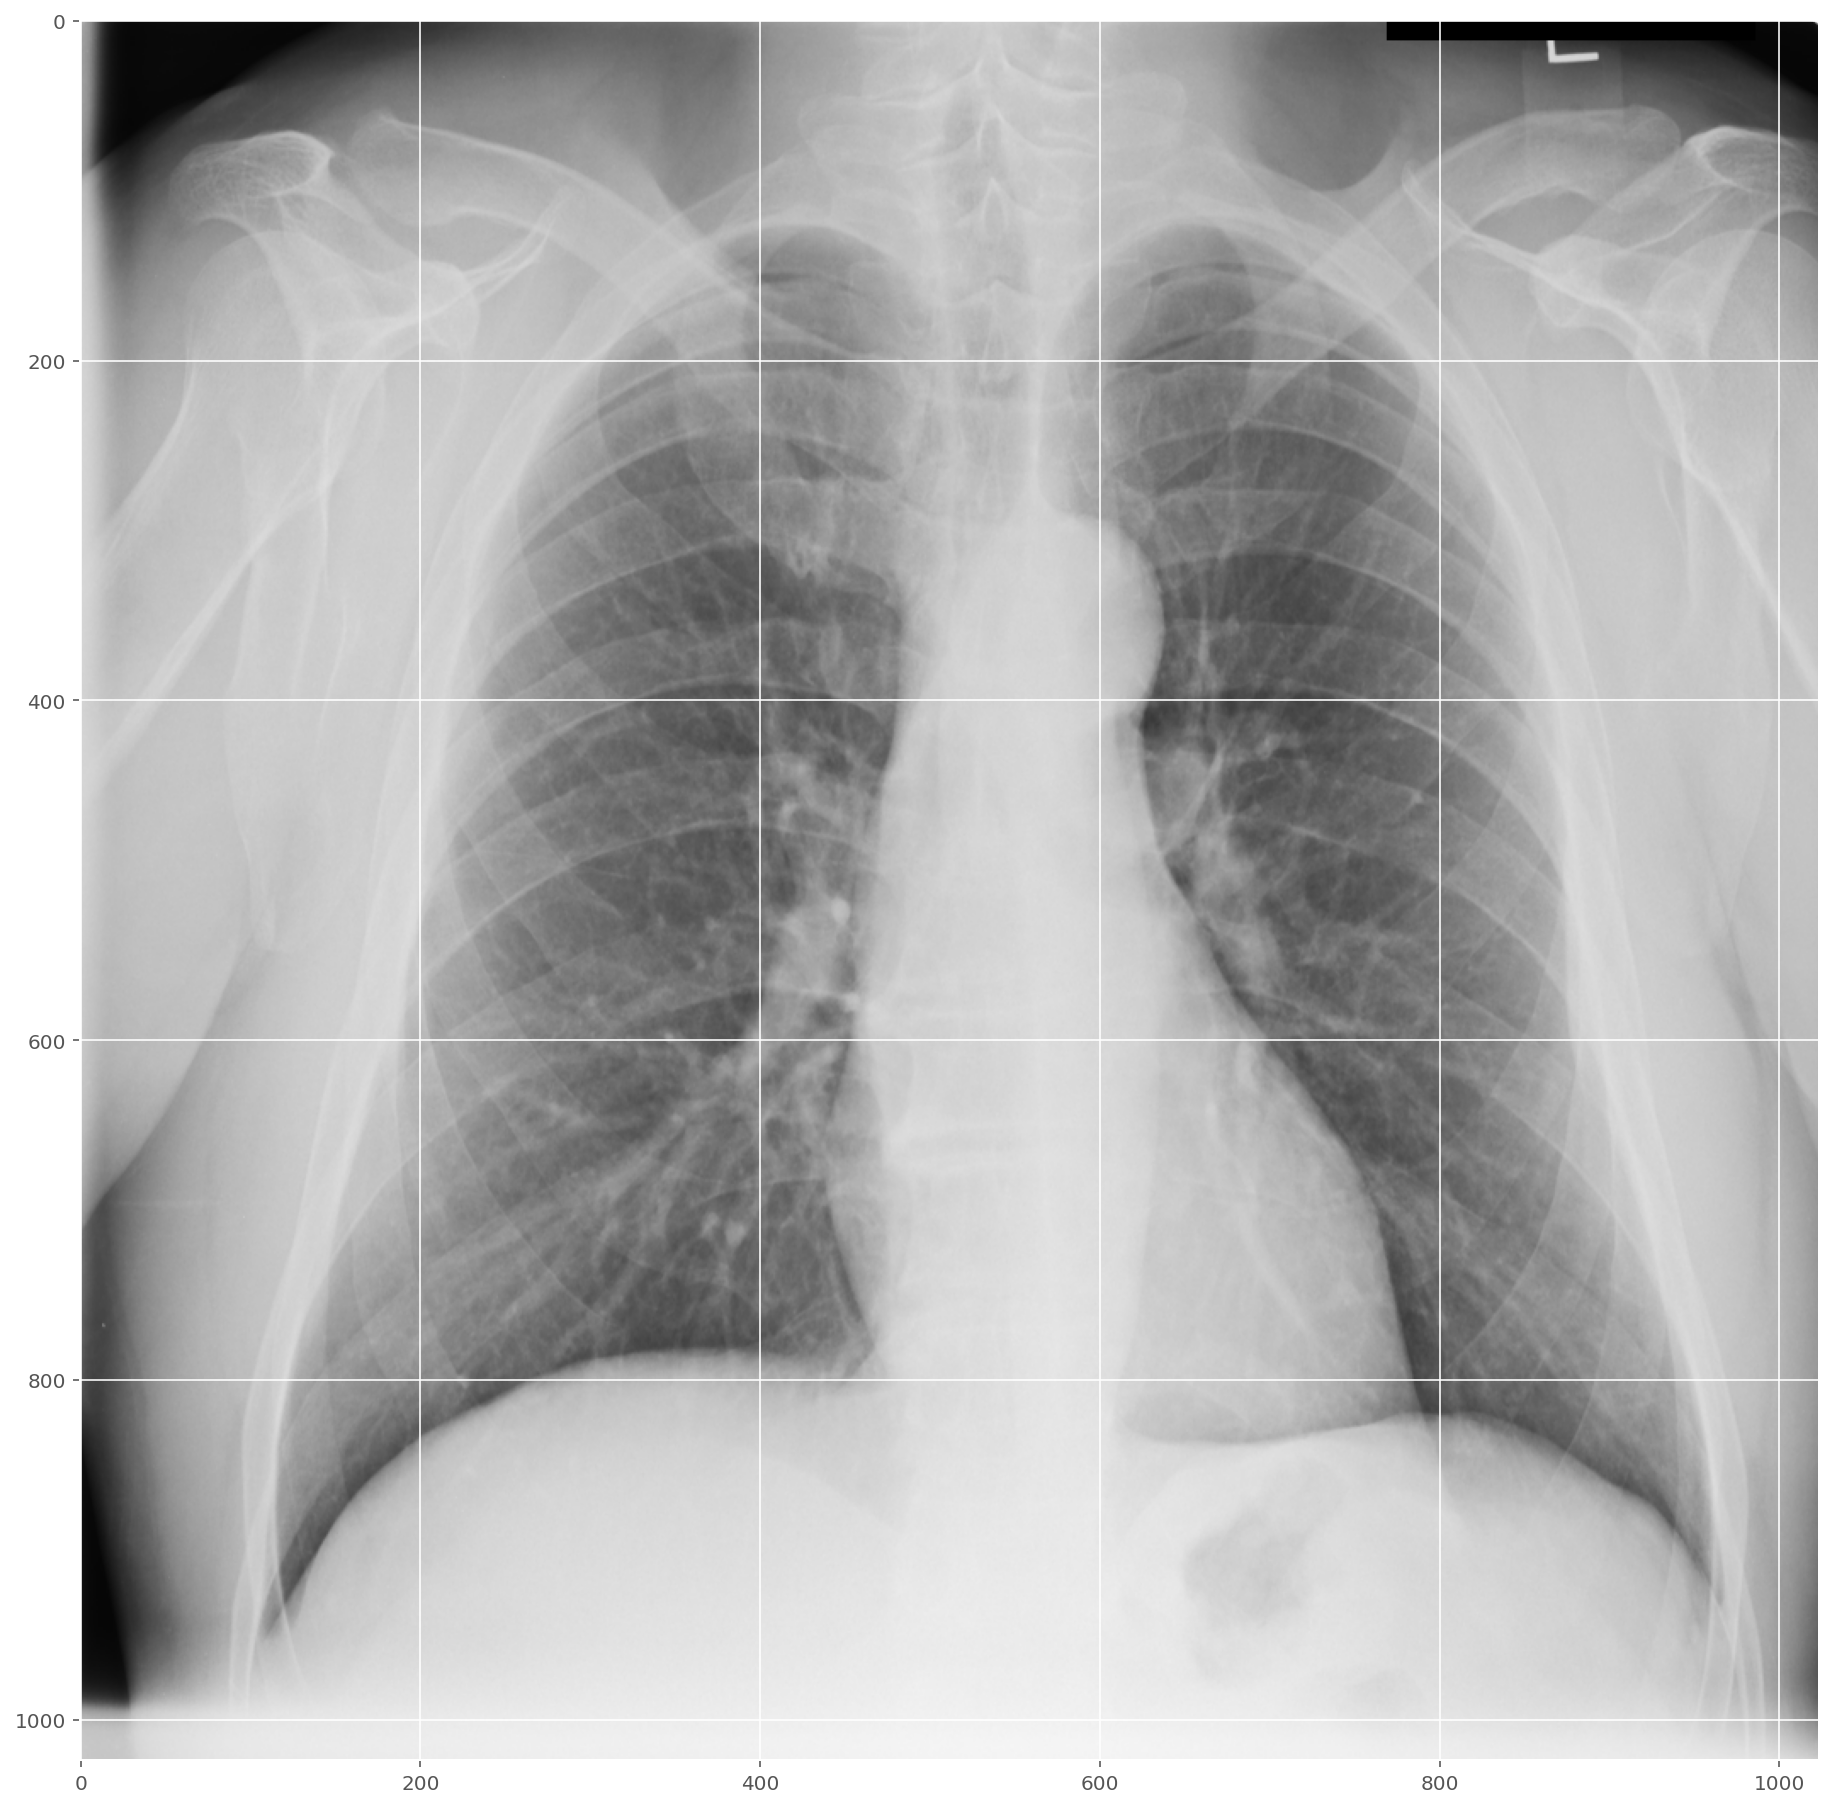

In [10]:
## Display a sample chest x-ray image.
plt.figure(figsize=(16,16))
plt.imshow(load_img('./data/images_001/images/00000057_003.png'))
plt.show()

In [11]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation.
## Load the NIH data to all_xray_df.
all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('./data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3, random_state=RND_STATE)

Scans found: 112120 , Total Headers 112120


Image Index            Finding Labels  Follow-up #  Patient ID  \
89645  00022260_003.png                No Finding            3       22260   
47446  00012048_007.png  Infiltration|Mass|Nodule            7       12048   
57963  00014352_005.png                No Finding            5       14352   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
89645           54              F            PA                 2542     2434   
47446           65              M            AP                 2500     2048   
57963            6              M            PA                 2992     2033   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
89645                        0.143  0.143          NaN   
47446                        0.168  0.168          NaN   
57963                        0.143  0.143          NaN   

                                            path  
89645  ./data\images_010\images\00022260_003.png  
47446  ./data\images_006\images\00012048_007.png  
57963  ./data\images_007\images\00014352_005.png

In [12]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column.

# Todo
findings = set()
for f in all_xray_df['Finding Labels'].unique():
    findings.update(f.split('|'))
print(f'Total number of single diagnoses in the data: {len(findings)}')

Total number of single diagnoses in the data: 15


In [13]:
for label in findings:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1. if label in finding else 0)
    print(f'%s: %d'%(label, int(all_xray_df[label].sum())))

Infiltration: 19894
Cardiomegaly: 2776
Mass: 5782
Edema: 2303
Consolidation: 4667
Effusion: 13317
Pneumothorax: 5302
Nodule: 6331
Fibrosis: 1686
Emphysema: 2516
Pneumonia: 1431
No Finding: 60361
Hernia: 227
Atelectasis: 11559
Pleural_Thickening: 3385


In [14]:
# for finding in findings:
#     all_xray_df[finding] = all_xray_df['Finding Labels'].map(lambda x: 1. if finding in x else 0)

all_xray_df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x  ...  Effusion  Pneumothorax Nodule  Fibrosis  \
0                        0.143  ...       0.0           0.0    0.0       0.0   
1                        0.143  ...       0.0           0.0    0.0       0.0   
2                        0.168  ...       1.0           0.0    0.0       0.0   
3                        0.171  ...       0.0           0.0    0.0       0.0   
4                        0.143  ...       0.0           0.0    0.0       0.0   

   Emphysema  Pneumonia  No Finding  Hernia  Atelectasis  Pleural_Thickening  
0        0.0        0.0         0.0     0.0          0.0                 0.0  
1        1.0        0.0         0.0     0.0          0.0                 0.0  
2        0.0        0.0         0.0     0.0          0.0                 0.0  
3        0.0        0.0         1.0     0.0          0.0                 0.0  
4        0.0        0.0         0.0     1.0          0.0                 0.0  

[5 rows x 28 columns]

In [15]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification.

# Todo
all_xray_df['pneumonia_class'] = all_xray_df.apply(
    lambda x: 'Positive' if x['Pneumonia']==1. else 'Negative', axis=1)

all_xray_df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x  ...  Pneumothorax  Nodule Fibrosis  Emphysema  \
0                        0.143  ...           0.0     0.0      0.0        0.0   
1                        0.143  ...           0.0     0.0      0.0        1.0   
2                        0.168  ...           0.0     0.0      0.0        0.0   
3                        0.171  ...           0.0     0.0      0.0        0.0   
4                        0.143  ...           0.0     0.0      0.0        0.0   

   Pneumonia  No Finding  Hernia  Atelectasis  Pleural_Thickening  \
0        0.0         0.0     0.0          0.0                 0.0   
1        0.0         0.0     0.0          0.0                 0.0   
2        0.0         0.0     0.0          0.0                 0.0   
3        0.0         1.0     0.0          0.0                 0.0   
4        0.0         0.0     1.0          0.0                 0.0   

   pneumonia_class  
0         Negative  
1         Negative  
2         Negative  
3         Negative  
4         Negative  

[5 rows x 29 columns]

In [16]:
all_xray_df[all_xray_df['pneumonia_class']=='Positive']

Image Index                                     Finding Labels  \
48      00000013_010.png                    Effusion|Pneumonia|Pneumothorax   
126     00000032_012.png          Atelectasis|Consolidation|Edema|Pneumonia   
253     00000056_000.png                                   Nodule|Pneumonia   
276     00000061_012.png  Edema|Effusion|Infiltration|Pleural_Thickening...   
279     00000061_015.png                                          Pneumonia   
...                  ...                                                ...   
111557  00030536_007.png                Atelectasis|Consolidation|Pneumonia   
111627  00030570_001.png                       Edema|Infiltration|Pneumonia   
111767  00030621_002.png                                          Pneumonia   
111845  00030637_016.png                            Consolidation|Pneumonia   
112115  00030801_001.png                                     Mass|Pneumonia   

        Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
48               10          13           60              M            AP   
126              12          32           55              F            AP   
253               0          56           76              M            PA   
276              12          61           77              M            AP   
279              15          61           77              M            AP   
...             ...         ...          ...            ...           ...   
111557            7       30536           56              F            AP   
111627            1       30570           29              F            AP   
111767            2       30621           22              F            AP   
111845           16       30637           48              M            AP   
112115            1       30801           39              M            PA   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
48                     3056     2544                        0.139  ...   
126                    2500     2048                        0.168  ...   
253                    2500     2048                        0.168  ...   
276                    3056     2544                        0.139  ...   
279                    3056     2544                        0.139  ...   
...                     ...      ...                          ...  ...   
111557                 3056     2544                        0.139  ...   
111627                 3056     2544                        0.139  ...   
111767                 3056     2544                        0.139  ...   
111845                 3056     2544                        0.139  ...   
112115                 2048     2500                        0.168  ...   

        Pneumothorax  Nodule Fibrosis  Emphysema  Pneumonia  No Finding  \
48               1.0     0.0      0.0        0.0        1.0         0.0   
126              0.0     0.0      0.0        0.0        1.0         0.0   
253              0.0     1.0      0.0        0.0        1.0         0.0   
276              0.0     0.0      0.0        0.0        1.0         0.0   
279              0.0     0.0      0.0        0.0        1.0         0.0   
...              ...     ...      ...        ...        ...         ...   
111557           0.0     0.0      0.0        0.0        1.0         0.0   
111627           0.0     0.0      0.0        0.0        1.0         0.0   
111767           0.0     0.0      0.0        0.0        1.0         0.0   
111845           0.0     0.0      0.0        0.0        1.0         0.0   
112115           0.0     0.0      0.0        0.0        1.0         0.0   

        Hernia  Atelectasis  Pleural_Thickening  pneumonia_class  
48         0.0          0.0                 0.0         Positive  
126        0.0          1.0                 0.0         Positive  
253        0.0          0.0                 0.0         Positive  
276        0.0          0.0                 1.0         Positive  
279        0.0

In [17]:
all_xray_df[all_xray_df['pneumonia_class']=='Positive'].shape

(1431, 29)

In [18]:
all_xray_df[all_xray_df['pneumonia_class']=='Negative']

Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_000.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112114  00030801_000.png              No Finding            0       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0                58              M            PA                 2682   
1                58              M            PA                 2894   
2                58              M            PA                 2500   
3                81              M            PA                 2500   
4                81              F            PA                 2582   
...             ...            ...           ...                  ...   
112114           39              M            PA                 2500   
112116           29              M            PA                 2048   
112117           42              F            PA                 2048   
112118           30              F            PA                 2048   
112119           27              M            PA                 2048   

        Height]  OriginalImagePixelSpacing[x  ...  Pneumothorax  Nodule  \
0          2749                        0.143  ...           0.0     0.0   
1          2729                        0.143  ...           0.0     0.0   
2          2048                        0.168  ...           0.0     0.0   
3          2048                        0.171  ...           0.0     0.0   
4          2991                        0.143  ...           0.0     0.0   
...         ...                          ...  ...           ...     ...   
112114     2048                        0.168  ...           0.0     0.0   
112116     2500                        0.168  ...           0.0     0.0   
112117     2500                        0.168  ...           0.0     0.0   
112118     2500                        0.168  ...           0.0     0.0   
112119     2500                        0.171  ...           0.0     0.0   

       Fibrosis  Emphysema  Pneumonia  No Finding  Hernia  Atelectasis  \
0           0.0        0.0        0.0         0.0     0.0          0.0   
1           0.0        1.0        0.0         0.0     0.0          0.0   
2           0.0        0.0        0.0         0.0     0.0          0.0   
3           0.0        0.0        0.0         1.0     0.0          0.0   
4           0.0        0.0        0.0         0.0     1.0          0.0   
...         ...        ...        ...         ...     ...          ...   
112114      0.0        0.0        0.0         1.0     0.0          0.0   
112116      0.0        0.0        0.0         1.0     0.0          0.0   
112117      0.0        0.0        0.0         1.0     0.0          0.0   
112118      0.0        0.0        0.0         1.0     0.0          0.0   
112119      0.0        0.0        0.0         1.0     0.0          0.0   

        Pleural_Thickening  pneumonia_class  
0                      0.0         Negative  
1                      0.0         Negative  
2                      0.0         Negative  
3                      0.0         Negative  
4                      0.0         Negative  
...                    ...              ...  
112114                 0.0         Negative  
112116                 0.0         Negative  
112117 

In [19]:
all_xray_df[all_xray_df['pneumonia_class']=='Negative'].shape

(110689, 29)

## Create your training and testing data:

In [20]:
def create_splits(**vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model.
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia.
    
    # Todo
    df = vargs['df']
    
    train_data, val_data = skl.train_test_split(df, test_size = .2, stratify=df['pneumonia_class'])
    train_data_ratio = len(train_data[train_data['pneumonia_class']=='Positive'])/len(train_data)
    val_data_ratio = len(val_data[val_data['pneumonia_class']=='Positive'])/len(val_data)
    print(f'Training set pneumonia: {100.*train_data_ratio: .2f}%\nValidation set pneumonia: {100.*val_data_ratio: .2f}%')
    
    # Make training set contain same number of positive and negative cases (balanced).
    train_pos_inds = train_data[train_data['pneumonia_class']=='Positive'].index.tolist()
    train_neg_inds = train_data[train_data['pneumonia_class']=='Negative'].index.tolist()

    # Randomly sample the train_neg_sample list to be of the same length as train_pos_inds.
    # Use the seed function for reproducibility.
    random.seed(RND_STATE)

    train_neg_sample = sample(train_neg_inds, len(train_pos_inds))
    train_data = train_data.loc[train_pos_inds+train_neg_sample]

    train_data_ratio = len(train_data[train_data['pneumonia_class']=='Positive'])/len(train_data)
    print(f'Training set corrected (50/50), Pneumonia: {100.*train_data_ratio: .2f}%')
    
    # Make validation set contain 80% positive and 20% negative cases.
    val_pos_inds = val_data[val_data['pneumonia_class']=='Positive'].index.tolist()
    val_neg_inds = val_data[val_data['pneumonia_class']=='Negative'].index.tolist()

    val_neg_sample = sample(val_neg_inds, 4*len(val_pos_inds))
    val_data = val_data.loc[val_pos_inds+val_neg_sample]

    val_data_ratio = len(val_data[val_data['pneumonia_class']=='Positive'])/len(val_data)
    print(f'Validation set corrected (20/80), Pneumonia: {100.*val_data_ratio :.2f}%')
    
    return train_data, val_data

In [21]:
train_data, val_data = create_splits(df=all_xray_df)

print(f'Training set size: {len(train_data)}\nValidation set size: {len(val_data)}')

Training set pneumonia:  1.28%
Validation set pneumonia:  1.28%
Training set corrected (50/50), Pneumonia:  50.00%
Validation set corrected (20/80), Pneumonia: 20.00%
Training set size: 2290
Validation set size: 1430


In [22]:
(train_data['pneumonia_class']=='Positive').value_counts()

True     1145
False    1145
Name: pneumonia_class, dtype: int64

In [23]:
(val_data['pneumonia_class']=='Negative').value_counts()

True     1144
False     286
Name: pneumonia_class, dtype: int64

We concur that both `train_data` and `val_data` have the correct number of positives/negative Pneumonia cases, in each set.

In [24]:
val_data['Patient Gender'].value_counts()

M    791
F    639
Name: Patient Gender, dtype: int64

#### Checking the `train_data` distribution for changes in the *Age* distribution of Male patients diagnosed with Pneumonia:

In [25]:
scipy.stats.ttest_ind(
    all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='M')],
    train_data['Patient Age'][(train_data['Pneumonia']==True) & (train_data['Patient Gender']=='M')])

Ttest_indResult(statistic=-0.010741585227633015, pvalue=0.991431037789108)

#### Checking the `train_data` distribution for changes in the *Age* distribution of Female patients diagnosed with Pneumonia:

In [26]:
scipy.stats.ttest_ind(
    all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='F')],
    train_data['Patient Age'][(train_data['Pneumonia']==True) & (train_data['Patient Gender']=='F')])

Ttest_indResult(statistic=-0.0919496879823014, pvalue=0.9267553707102112)

In [27]:
train_data['Patient Gender'].value_counts()

M    1321
F     969
Name: Patient Gender, dtype: int64

We concur that the training data, after sampling, revealed **57.9%** male patients and **42.1%** female patients.

#### Checking the `val_data` distribution for changes in the *Age* distribution of Male patients diagnosed with Pneumonia:

In [28]:
scipy.stats.ttest_ind(
    all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='M')],
    val_data['Patient Age'][(val_data['Pneumonia']==True) & (val_data['Patient Gender']=='M')])

Ttest_indResult(statistic=0.02787788862416245, pvalue=0.9777651117746642)

#### Checking the `val_data` distribution for changes in the *Age* distribution of Female patients diagnosed with Pneumonia:

In [29]:
scipy.stats.ttest_ind(
    all_xray_df['Patient Age'][(all_xray_df['Pneumonia']== True) & (all_xray_df['Patient Gender']=='F')],
    val_data['Patient Age'][(val_data['Pneumonia']==True) & (val_data['Patient Gender']=='F')])

Ttest_indResult(statistic=0.22126928123540315, pvalue=0.8249460304527414)

In [30]:
val_data['Patient Gender'].value_counts()

M    791
F    639
Name: Patient Gender, dtype: int64

We concur that the validation data, after sampling, revealed **56.64%** male patients and **44.41%** female patients.

> Note that the **TTests** depicted above revealed that both **Age** and **Gender** data distributions, in both `train_data` and `val_data`, reflect the general data's demographic of distributions.

In [31]:
train_data['View Position'].value_counts()

PA    1191
AP    1099
Name: View Position, dtype: int64

We concur that the training data, after sampling, revealed **52.4%** PAand **47.6%** AP viewing positions.

In [32]:
val_data['View Position'].value_counts()

PA    830
AP    600
Name: View Position, dtype: int64

We concur that the validation data, after sampling, revealed **55.66%** PAand **44.34%** AP viewing positions.

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [33]:
## Hyperparameter setup.
IMG_SIZE = (224, 224) # Used for data augmentation.
TARGET_SIZE = (512, 512) # Used for data augmentation.
LR_RATE = 1e-4 # Learning rate.
LOSS = 'binary_crossentropy' # Loss function.
METRICS = [ # Accuracy metrics.
    'binary_accuracy']
NUM_EPOCHS = 10 # Number of epochs.

## When it comes to "Out Of Memory" (OOM) errors when training,
# the most straightforward thing to do is to reduce the BATCH_SIZE hyperparameter.
BATCH_SIZE = 32 # Batch size.

In [34]:
def my_image_augmentation(**vargs):
    
    ## Recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations.
    
    ## Keep an eye out for types of augmentation that are or are not appropriate for medical imaging data.
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data.
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package.
    
    # Args.
    rotation = vargs['rotation'] if 'rotation' in vargs else 20
    shear = vargs['shear'] if 'shear' in vargs else .15
    zoom = vargs['zoom'] if 'rotation' in vargs else .12
    train = vargs['train']
    
    if train == True:
        my_idg = ImageDataGenerator(
            rescale=1./255., 
            horizontal_flip=True, 
            vertical_flip=False, 
            height_shift_range=.1, 
            width_shift_range=.1, 
            rotation_range=rotation, 
            shear_range=shear,
            zoom_range=zoom)
    else:
        my_idg = ImageDataGenerator(rescale=1./255.)
    
    return my_idg


## Create the actual generators using the output of my_image_augmentation for your training data.
def make_train_gen(**vargs):
        
    # Args.
    df = vargs['df']
    
    aug = my_image_augmentation(**vargs)
    
    # Suggestion here to use the flow_from_dataframe library:
    train_gen = aug.flow_from_dataframe(
        dataframe=df, 
        directory=None, 
        x_col='path',
        y_col='pneumonia_class',
        class_mode='binary',
        target_size=IMG_SIZE, 
        batch_size=BATCH_SIZE,
        seed=RND_STATE)

    return train_gen


def make_val_gen(**vargs):
        
    # Args.
    df = vargs['df']
    
    aug = my_image_augmentation(**vargs)
        
    val_gen = aug.flow_from_dataframe(
        dataframe=df, 
        directory=None, 
        x_col='path',
        y_col='pneumonia_class',
        class_mode='binary',
        target_size=IMG_SIZE, 
        batch_size=len(val_data),
        seed=RND_STATE)

    return val_gen

In [35]:
train_gen = make_train_gen(df=train_data, train=True)
val_gen = make_val_gen(df=val_data, train=False)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [36]:
train_gen.class_indices

{'Negative': 0, 'Positive': 1}

In [37]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

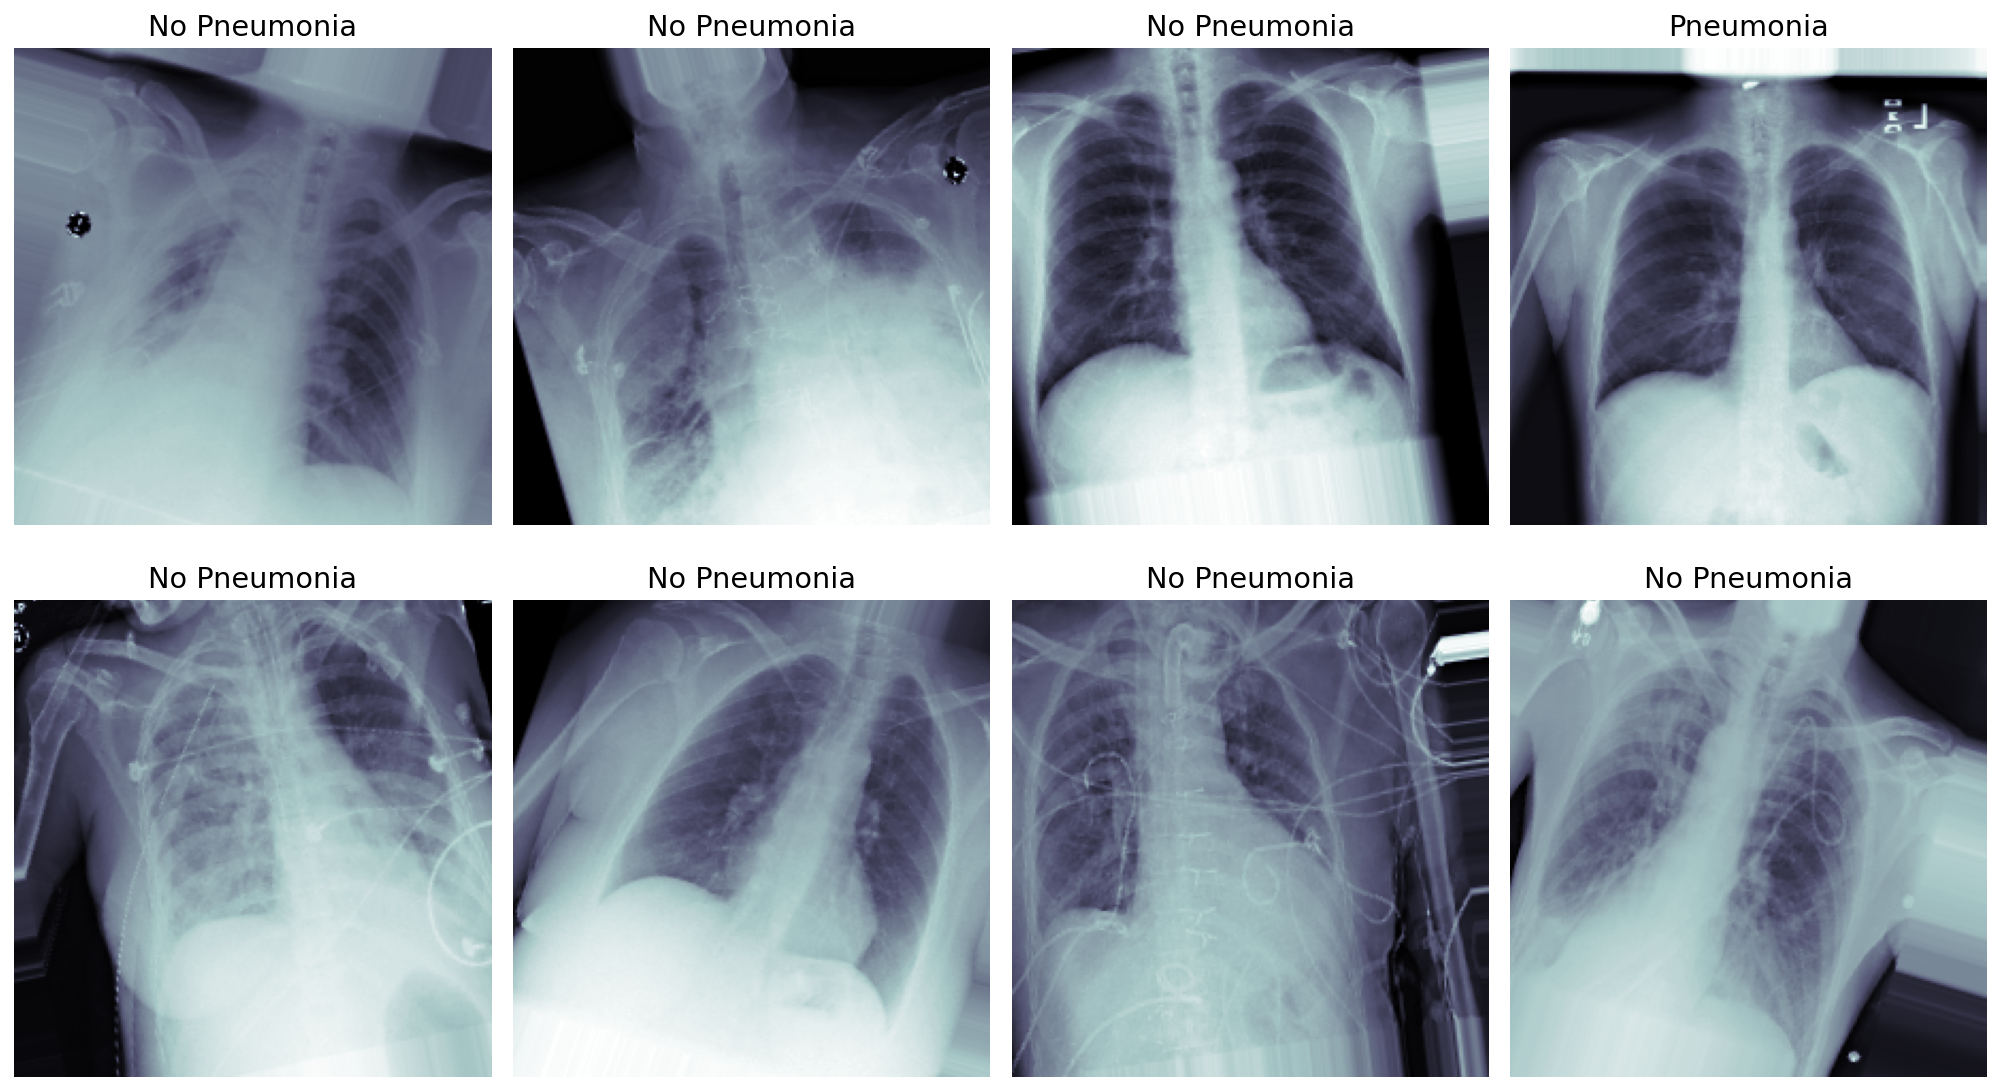

<Figure size 432x288 with 0 Axes>

In [38]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation.

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize=(14,8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap='bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')
    c_ax.set_visible(True)
fig.tight_layout()    
fig.savefig('./out/examples_of_augmented_training_data.png', dpi=300)
plt.show()
plt.draw()

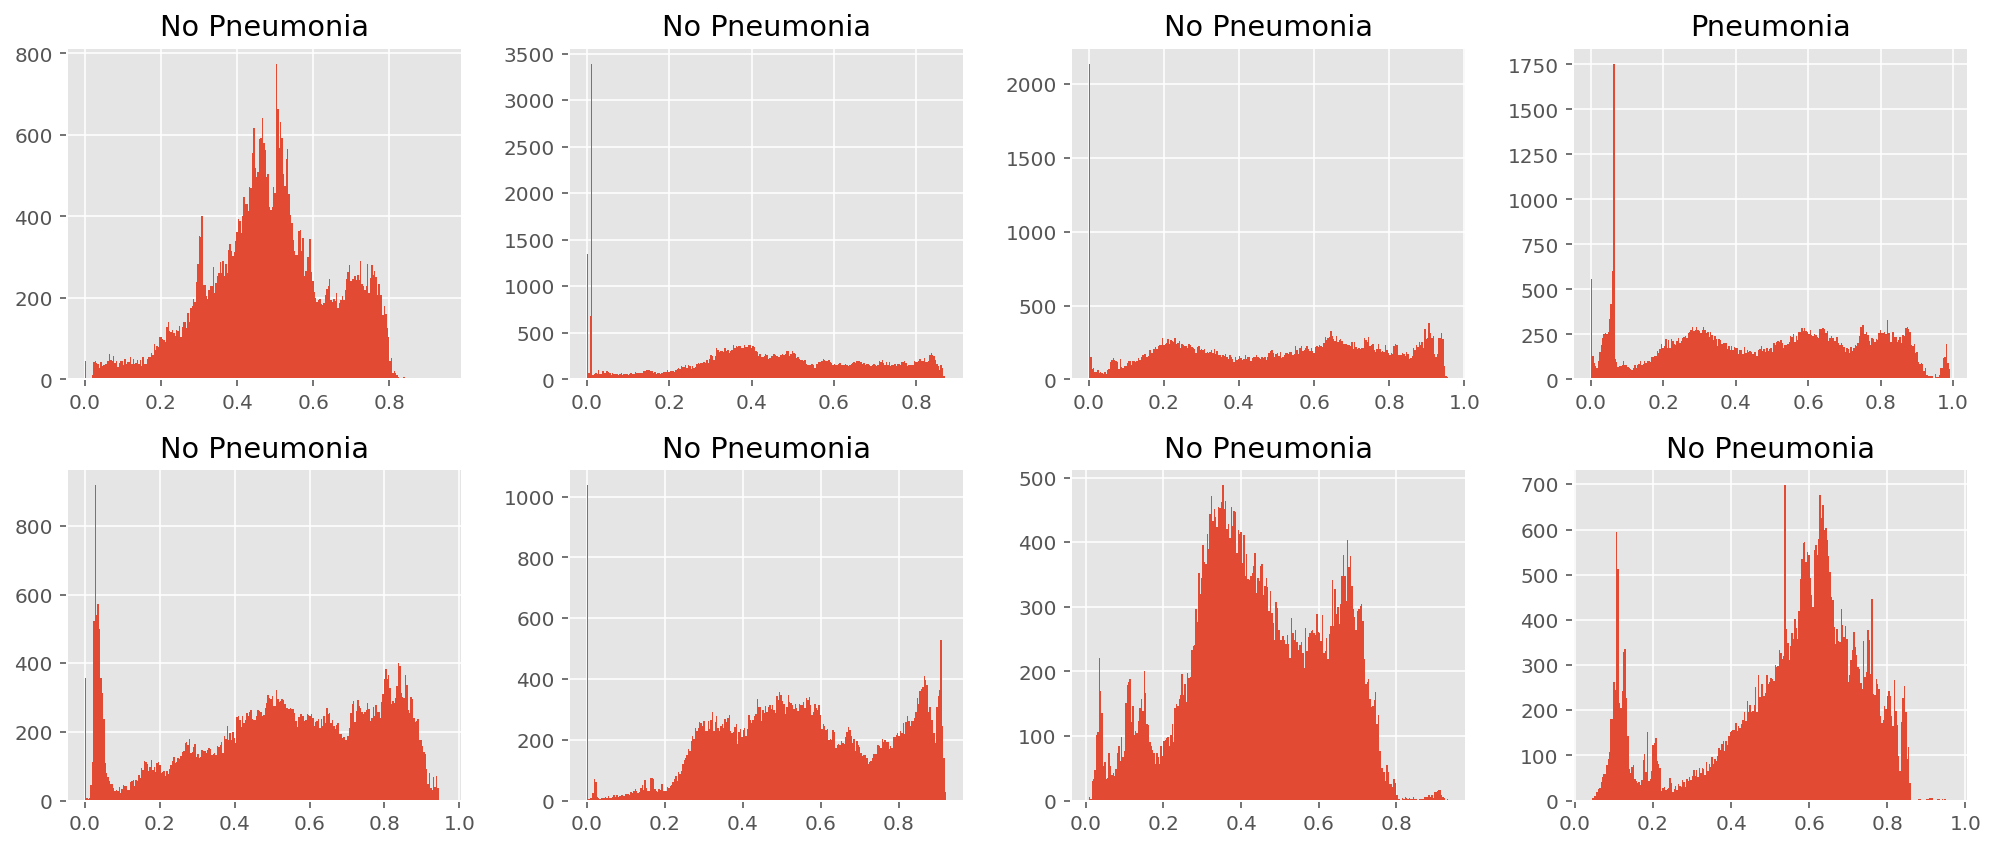

<Figure size 432x288 with 0 Axes>

In [39]:
fig, m_axs = plt.subplots(2, 4, figsize=(14,6))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.hist(c_x[:,:,0].flatten(), bins=256)
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.set_visible(True)
fig.tight_layout()
fig.savefig('./out/examples_of_augmented_training_data_hist.png', dpi=300)
plt.show()
plt.draw()

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning.

In [40]:
## Loads the pre-trained model.
def load_pretrained(**vargs):
    
    # Import the pre-trained model.
    pretrained_model = VGG16(include_top=True, weights='imagenet') # input_shape=(512,512,3)
    transfer_layer = pretrained_model.get_layer('block5_pool')
    model = Model(inputs=pretrained_model.input, outputs=transfer_layer.output)
    
    # Trainable?
#     for layer in model.layers[0:17]:
#         layer.trainable = True # False
    
    print('{} Layers:'.format(pretrained_model.name.upper()))
    for layer in model.layers:
        print(f'%s: Trainable? %s' % (layer.name, layer.trainable))
    
    return model

In [41]:
def build(**vargs):
        
    # Loads the pre-trained model.
    pretrained_model = load_pretrained()
    
    # Args.
    end_layer_freeze_at = vargs['end_layer_freeze_at']
    specific_layer = vargs['specific_layer']
    fc_list = vargs['fc_list']
    model_name = vargs['name']
    
    if specific_layer == None:        
        for layer in pretrained_model.layers[0:end_layer_freeze_at]:
            layer.trainable = False
            
    else: # If specific_layer != False.
        for ind, layer in enumerate(pretrained_model.layers):
            if ind != specific_layer: 
                layer.trainable = False
                
        for layer in pretrained_model.layers:
            print(layer.name, layer.trainable)

    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.).
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile.
    
    # Also make sure you set your optimizer, loss function, and metrics to monitor.
    model = Sequential(name=model_name)
    model.add(pretrained_model)

    # Flatten the output of the model because it is from a convolutional layer.
    model.add(Flatten())

    if len(fc_list) > 0:
        for i, num in enumerate(fc_list):    
            model.add(Dropout(.5))
            model.add(Dense(num, activation='relu'))
    
    model.add(Dropout(.5))
    
    # Dence layer.
    model.add(Dense(1, activation='sigmoid'))
    
    # Model optimization: define the learning rate, loss, and metrics.
    optimizer = Adam(lr=LR_RATE)
    
    # Compile the model.
    model.compile(optimizer=optimizer, loss=LOSS, metrics=METRICS)
    
    return model


## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results.

In [42]:
pretrained_model = load_pretrained()

VGG16 Layers:
input_1: Trainable? True
block1_conv1: Trainable? True
block1_conv2: Trainable? True
block1_pool: Trainable? True
block2_conv1: Trainable? True
block2_conv2: Trainable? True
block2_pool: Trainable? True
block3_conv1: Trainable? True
block3_conv2: Trainable? True
block3_conv3: Trainable? True
block3_pool: Trainable? True
block4_conv1: Trainable? True
block4_conv2: Trainable? True
block4_conv3: Trainable? True
block4_pool: Trainable? True
block5_conv1: Trainable? True
block5_conv2: Trainable? True
block5_conv3: Trainable? True
block5_pool: Trainable? True


In [43]:
pretrained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [44]:
## Get the names of layers of the CNN model:
layer_names = [layer.name for layer in pretrained_model.layers]
layer_names

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool']

In [45]:
## Get the output of the layers of the CNN model:
layer_outputs = [layer.output for layer in pretrained_model.layers]
layer_outputs

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 224, 224, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 112, 112, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 112, 112, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 56, 56, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 28, 28, 256) dtype=float32 (created by layer 'block3_pool')>,


In [46]:
## Generate feature maps from the CNN model and log them:
# feature_maps = pretrained_model.predict(pretrained_model.input)

# for layer_name, feature_map in zip(
#     layer_names,
#     feature_maps):print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

## Model 1 (VGG16_v1)

### About

- The architecture of **Model 1** uses the last output layer from the downloaded **VGG16** pretrained model. No dropout layers were added to the model. Also, no FC-layers were added to the model.
- **Model 1** is assumed to run for 15 epochs to observe the learning outcomes.
- Due to a **VRAM** limitation currently present in the working computer, the `BATCH_SIZE` hyperparameter was reduced to just 8 – to avoid the so called "Out of Memory" (OOM) errors witnessed during the initial training sessions of the model. GPU’s VRAM is 10 GB for reference.

In [47]:
vgg_model_v1 = build(
    name="VGG16_v1",
    end_layer_freeze_at=-1,
    specific_layer=None,
    fc_list=[])

VGG16 Layers:
input_2: Trainable? True
block1_conv1: Trainable? True
block1_conv2: Trainable? True
block1_pool: Trainable? True
block2_conv1: Trainable? True
block2_conv2: Trainable? True
block2_pool: Trainable? True
block3_conv1: Trainable? True
block3_conv2: Trainable? True
block3_conv3: Trainable? True
block3_pool: Trainable? True
block4_conv1: Trainable? True
block4_conv2: Trainable? True
block4_conv3: Trainable? True
block4_pool: Trainable? True
block5_conv1: Trainable? True
block5_conv2: Trainable? True
block5_conv3: Trainable? True
block5_pool: Trainable? True


In [48]:
vgg_model_v1.summary()

Model: "VGG16_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


### Start training! 

In [49]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Add checkpoints to your model.
# This will save the 'best' version of your model by comparing it to previous epochs of training.
def add_checkpoints(**vargs):
    
    # Args.
    model = vargs['model']
    
    weight_path = "./out/{}_{}.best.hdf5".format('xray_classification', model.name)

    checkpoint = ModelCheckpoint(
        weight_path,
        monitor='val_loss', 
        mode='min',
        verbose=1,
        save_best_only=True,
        save_weights_only=True)

    callbacks_list = [checkpoint, EarlyStopping(monitor='val_loss', mode='min', patience=10)]
    
    return weight_path, callbacks_list

In [50]:
weight_path, callbacks_list = add_checkpoints(model=vgg_model_v1)

In [51]:
## train your model.
history = vgg_model_v1.fit_generator(
    train_gen, 
    validation_data=(valX, valY), 
    epochs=NUM_EPOCHS,
    callbacks=callbacks_list)

Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 0.7517 - binary_accuracy: 0.5306
Epoch 00001: val_loss improved from inf to 0.77507, saving model to ./out\xray_classification_VGG16_v1.best.hdf5
72/72 [==============================] - 43s 532ms/step - loss: 0.7517 - binary_accuracy: 0.5306 - val_loss: 0.7751 - val_binary_accuracy: 0.3189
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 0.7415 - binary_accuracy: 0.5262
Epoch 00002: val_loss improved from 0.77507 to 0.68907, saving model to ./out\xray_classification_VGG16_v1.best.hdf5
72/72 [==============================] - 33s 464ms/step - loss: 0.7415 - binary_accuracy: 0.5262 - val_loss: 0.6891 - val_binary_accuracy: 0.5469
Epoch 3/10
72/72 [==============================] - ETA: 0s - loss: 0.7094 - binary_accuracy: 0.5790
Epoch 00003: val_loss improved from 0.68907 to 0.65555, saving model to ./out\xray_classification_VGG16_v1.best.hdf5
72/72 [==============================] - 33s 458ms/step - 

In [52]:
evaluation = vgg_model_v1.evaluate(train_gen)

print(f"Train loss: {evaluation[0] * 100:.2f}%")
print(f"Train accuracy: {evaluation[1] * 100:.2f}%")

72/72 [==============================] - 32s 438ms/step - loss: 0.6837 - binary_accuracy: 0.5769
Train loss: 68.37%
Train accuracy: 57.69%


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project.

In [53]:
## Log the performance statistics.
performance = []

In [54]:
history_df = pd.DataFrame(history.history)

performance.append(history_df[history_df['val_loss']==min(history_df['val_loss'])])
performance

[       loss  binary_accuracy  val_loss  val_binary_accuracy
 6  0.676528         0.603493  0.598863             0.688811]

In [55]:
## After training, make some predictions to assess your model's overall performance.
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
vgg_model_v1.load_weights(weight_path)
pred_Y = vgg_model_v1.predict(valX, batch_size=BATCH_SIZE, verbose=True)

45/45 [==============================] - 2s 33ms/step


In [56]:
pred_Y.shape

(1430, 1)

In [57]:
## Save model history (i.e., train results) to a .csv file.
def save_history_df_to_file(model):
    
    path = "./out/{}_{}.csv".format('history_df', model.name)
    history_df.to_csv(path)
    return

In [58]:
save_history_df_to_file(vgg_model_v1)

### Visualization plots (helper functions):

In [59]:
## Hint: can use scikit-learn's built in functions here like roc_curve.

FIG_SIZE = (16, 4)


def plot_auc(model, t_y, p_y):
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)    
    ax.plot(fpr, tpr, label='AUC = %0.4f' % (auc(fpr, tpr)))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.legend(loc='best', fontsize='large')
    ax.set_title('{} ROC Curve'.format(model.name))
    fig.savefig('./out/{}_ROC_Curve.png'.format(model.name), dpi=300)
    return

    
## What other performance statistics do you want to include here besides AUC?

def plot_f1_scores(model, t_y, p_y):
    
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)

    # Compute F1.
    def f1(threshold):

        for i, t in enumerate(thresholds):
            if t > threshold:
                f1_sc = calc_f1_score(precision[i], recall[i])
                if not math.isnan(f1_sc):
                    return f1_sc
                else: 
                    return 0
        return 0

    f1_scores = [f1(t) for t in thresholds]
    idx = np.argmax(np.array(f1_scores, dtype=np.float32))
    
    fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)    
    ax.plot(thresholds, f1_scores, label='Threshold at MAX F1-score = %.4f' % (thresholds[idx]))
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1-score') 
    ax.legend(loc='best', fontsize='large')
    ax.set_title('{} F1-scores by Threshold'.format(model.name))
    fig.savefig('./out/{}_F1_scores_by_Threshold.png'.format(model.name), dpi=300)
    return

    
def plot_prec_recall(model, t_y, p_y):
    
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)    
    ax.plot(recall, precision)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('{} Precision/Recall Curve'.format(model.name))
    fig.savefig('./out/{}_Precision_Recall_Curve.png'.format(model.name), dpi=300)
    return


def plot_prec_recall_by_threshold(model, t_y, p_y):
    
    plt.figure(figsize=FIG_SIZE)
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(thresholds, precision[:-1], lw=2, label='Precision')
    plt.plot(thresholds, recall[:-1], lw=2, label='Recall')
    plt.legend(loc='best', fontsize='large')
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall')
    plt.title('{} Precision/Recall by Threshold'.format(model.name))
    plt.savefig('./out/{}_Precision_Recall_by_Threshold.png'.format(model.name), dpi=300)
    plt.show()

    
def plot_f1_recall_by_threshold(model, t_y, p_y):
    
    # Compute F1.
    def f1(threshold):

        for i, t in enumerate(thresholds):
            if t > threshold:
                f1_sc = calc_f1_score(precision[i], recall[i])
                if not math.isnan(f1_sc):
                    return f1_sc
                else: 
                    return 0
        return 0

    precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
    f1_scores = [f1(t) for t in thresholds]
    
    plt.figure(figsize=FIG_SIZE)
    plt.plot(thresholds, recall[:-1], lw=2, label='Recall')
    plt.plot(thresholds, f1_scores, label='F1-score')
    plt.xlabel('Threshold')
    plt.ylabel('F1-score')
    plt.legend(loc='best', fontsize='large')
    plt.title('{} F1-scores by Threshold'.format(model.name))
    plt.savefig('./out/{}_F1_scores_by_Threshold.png'.format(model.name), dpi=300)
    plt.show()    

    
## Also consider plotting the history of your model training:

def plot_acc(model, history):
    
    x_vals = np.arange(0, len(history.history["loss"]))
    metrics = ["binary_accuracy", "val_binary_accuracy"]
    labels = ["train_acc", "val_acc"]
    plt.figure(figsize=FIG_SIZE)
    for i, metric in enumerate(metrics):
        plt.plot(x_vals,
                 history.history[metric],
                 label=labels[i])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="best", fontsize='large')
    plt.title('{} Training Evolution (Accuracy)'.format(model.name))
    plt.savefig('./out/{}_Training_Evolution_Accuracy.png'.format(model.name), dpi=300)
    plt.show()

    
def plot_loss(model, history):
    
    x_vals = np.arange(0, len(history.history["loss"]))
    metrics = ["loss", "val_loss"]
    labels = ["train_loss", "val_loss", "train_acc", "val_acc"]
    plt.figure(figsize=FIG_SIZE)
    for i, metric in enumerate(metrics):
        plt.plot(x_vals,
                 history.history[metric],
                 label=labels[i])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="best", fontsize='large')
    plt.title('{} Training Evolution (Losses)'.format(model.name))
    plt.savefig('./out/{}_Training_Evolution_Losses.png'.format(model.name), dpi=300)
    plt.show()
    
    
## Plot the history of your model training.
def plot_history(model, history):
    
    plot_acc(model, history)
    plot_loss(model, history)

In [60]:
# Calculate the F1-score metric.
def calc_f1_score(prec, recall):
    
    return (2. * (prec*recall) / (prec+recall))


# Obtain the threshold at maximum f1_score => best threshold.
# This function finds the threshold at maximum f1_score computed from precision and recall values.
# It attepts to log the threshold and the corresponding precision and recall values.
def calc_best_threshold(precision, recall):
    
    f1_score = calc_f1_score(precision, recall)
    
    # Find and save the index (idx_max) at maximum f1_score.
    idx_max = np.nanargmax(f1_score)
    best_threshold = thresholds[idx_max]
    
    # Log the corresponding threshold, precision and recall values.
    print(f'Threshold that maximized the F1-score: %.4f' % best_threshold)
    print(f'Corresponding Precision: %.2f' % precision[idx_max])
    print(f'Recall: %.2f' % recall[idx_max])
    
    return best_threshold

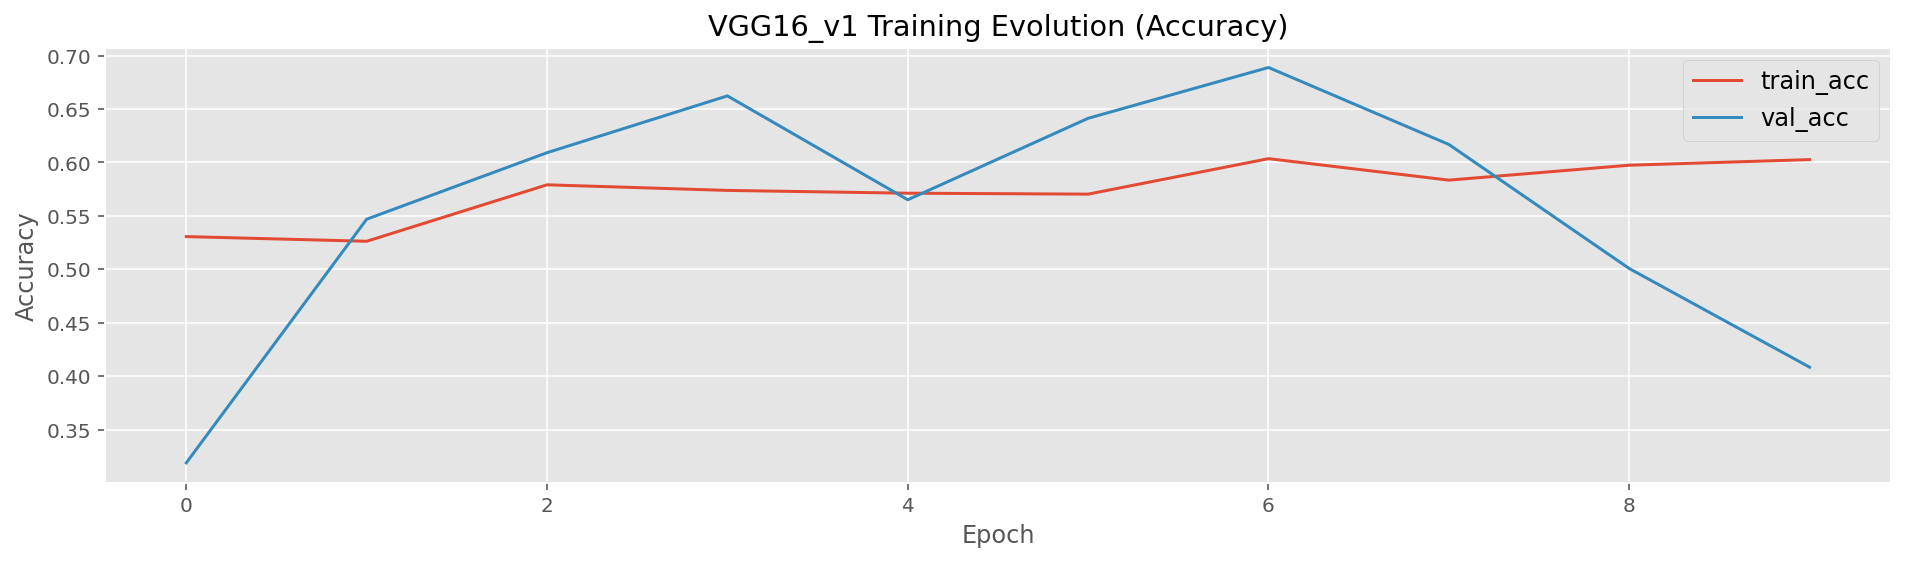

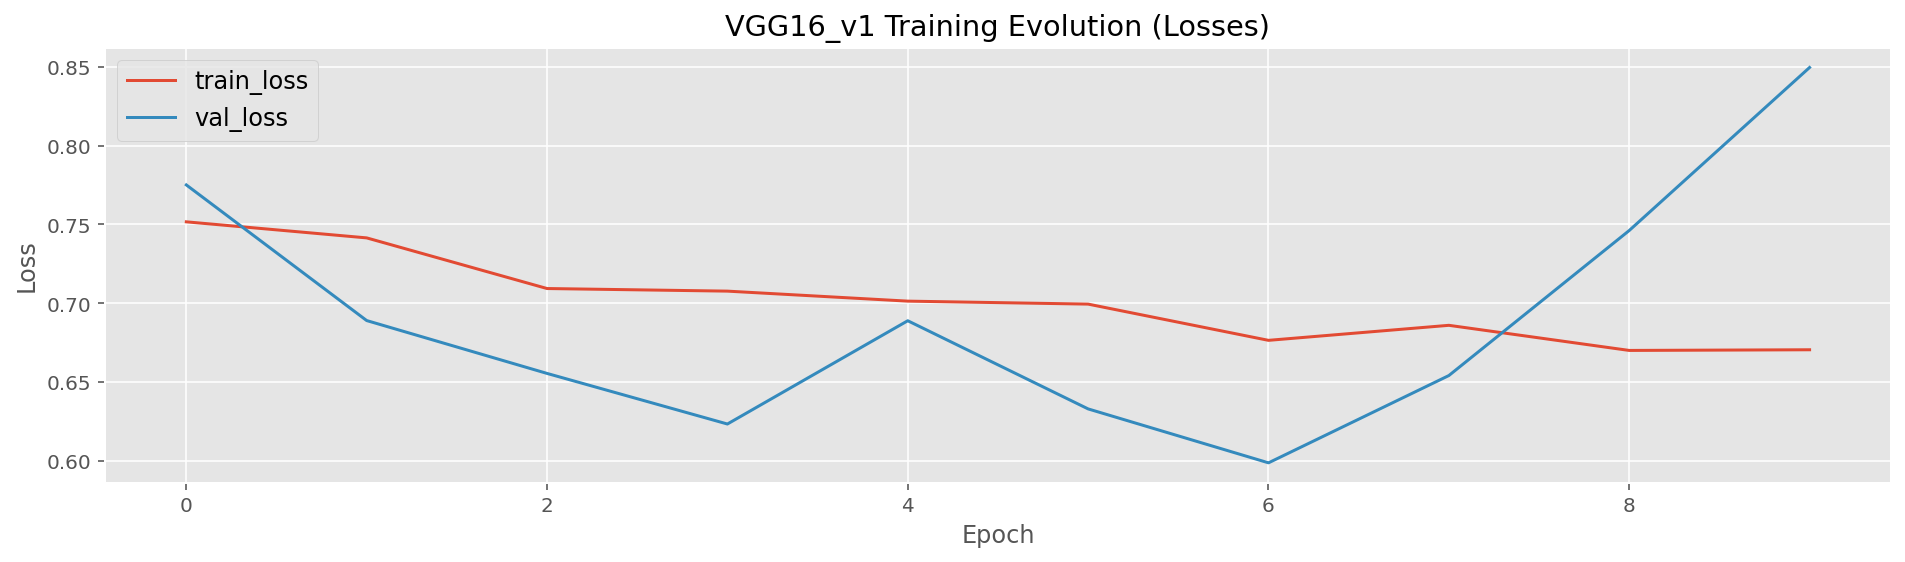

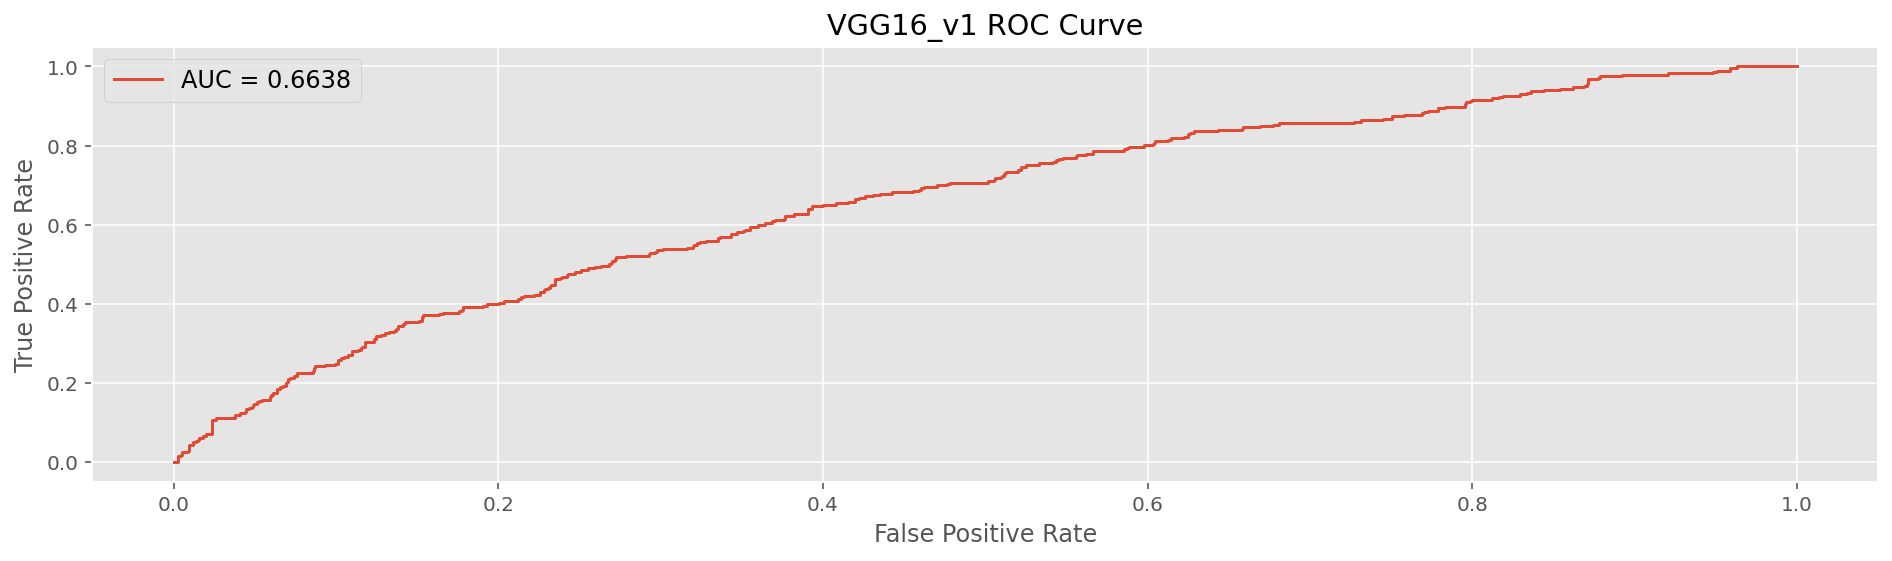

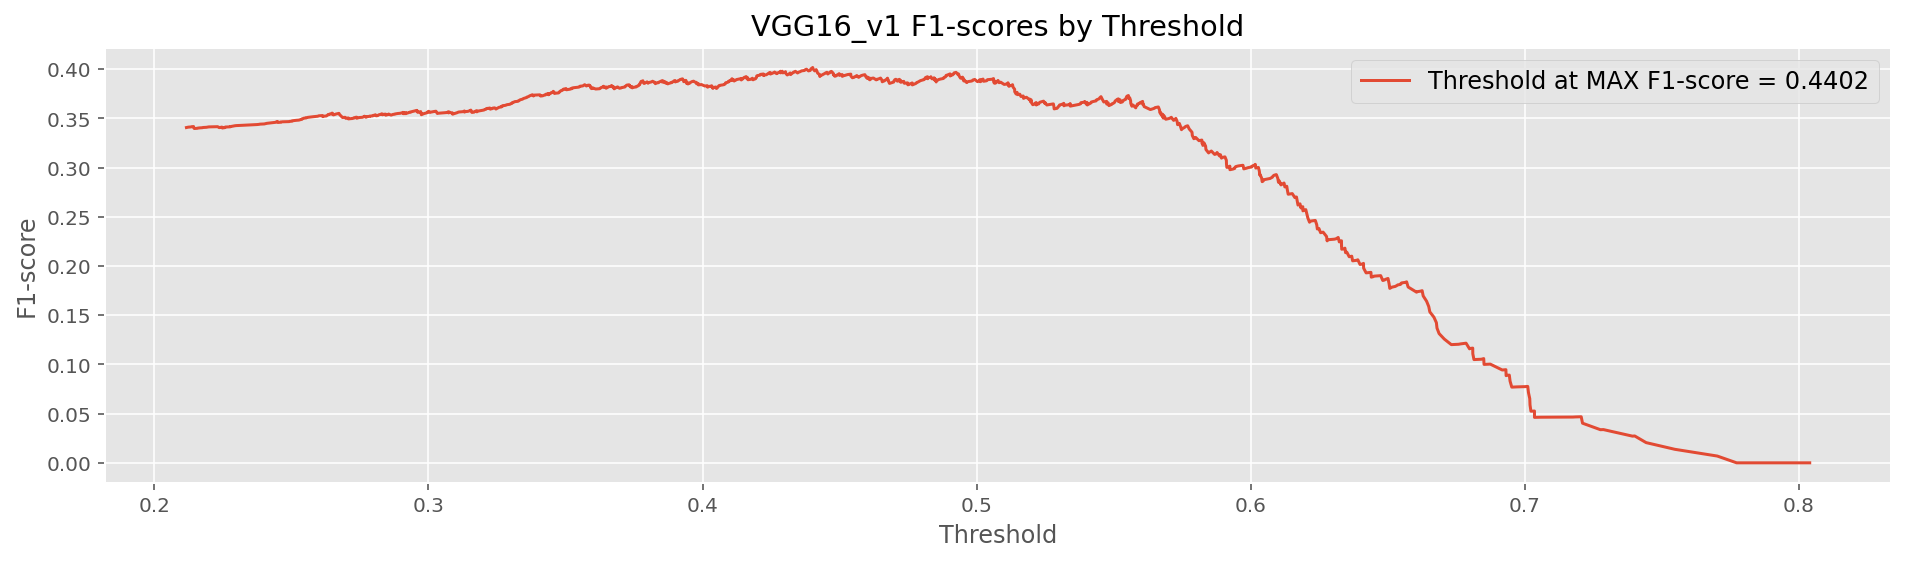

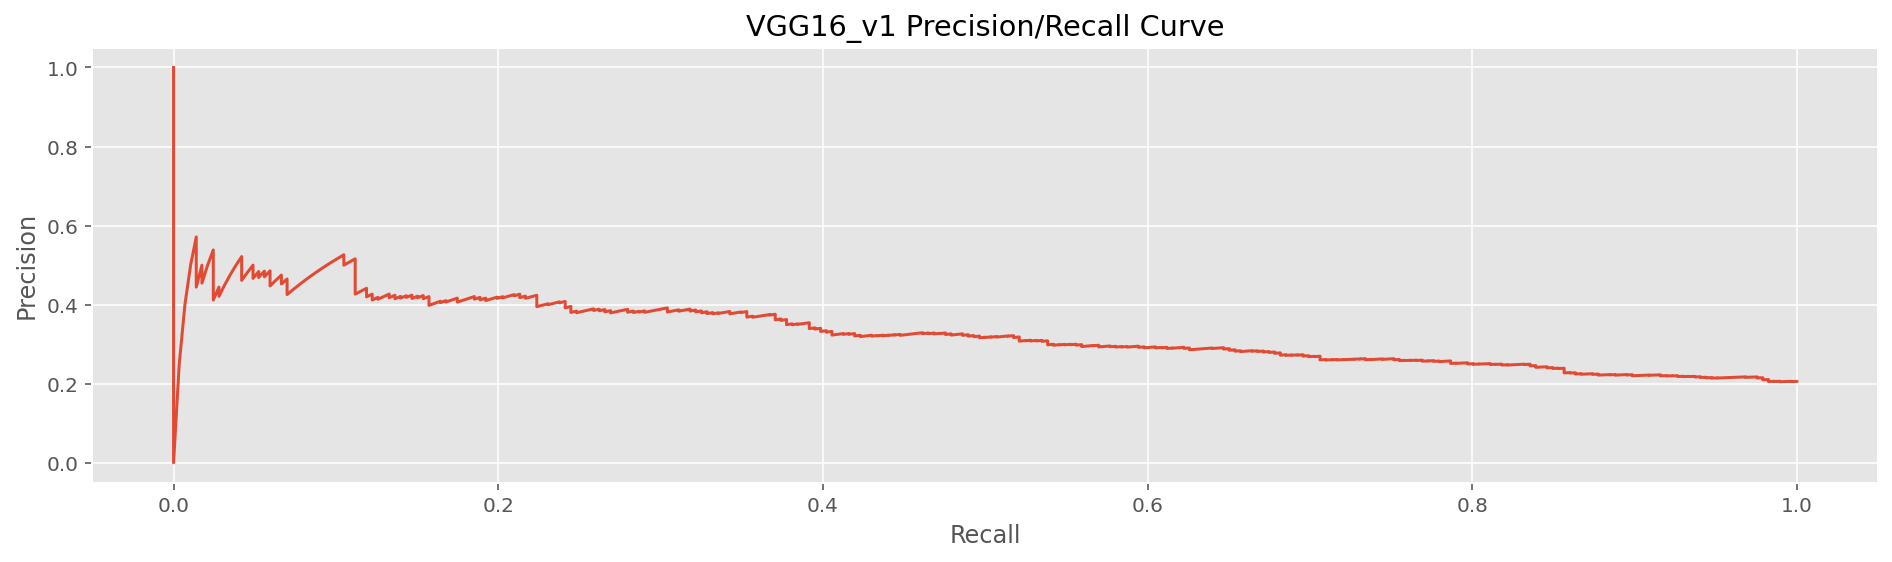

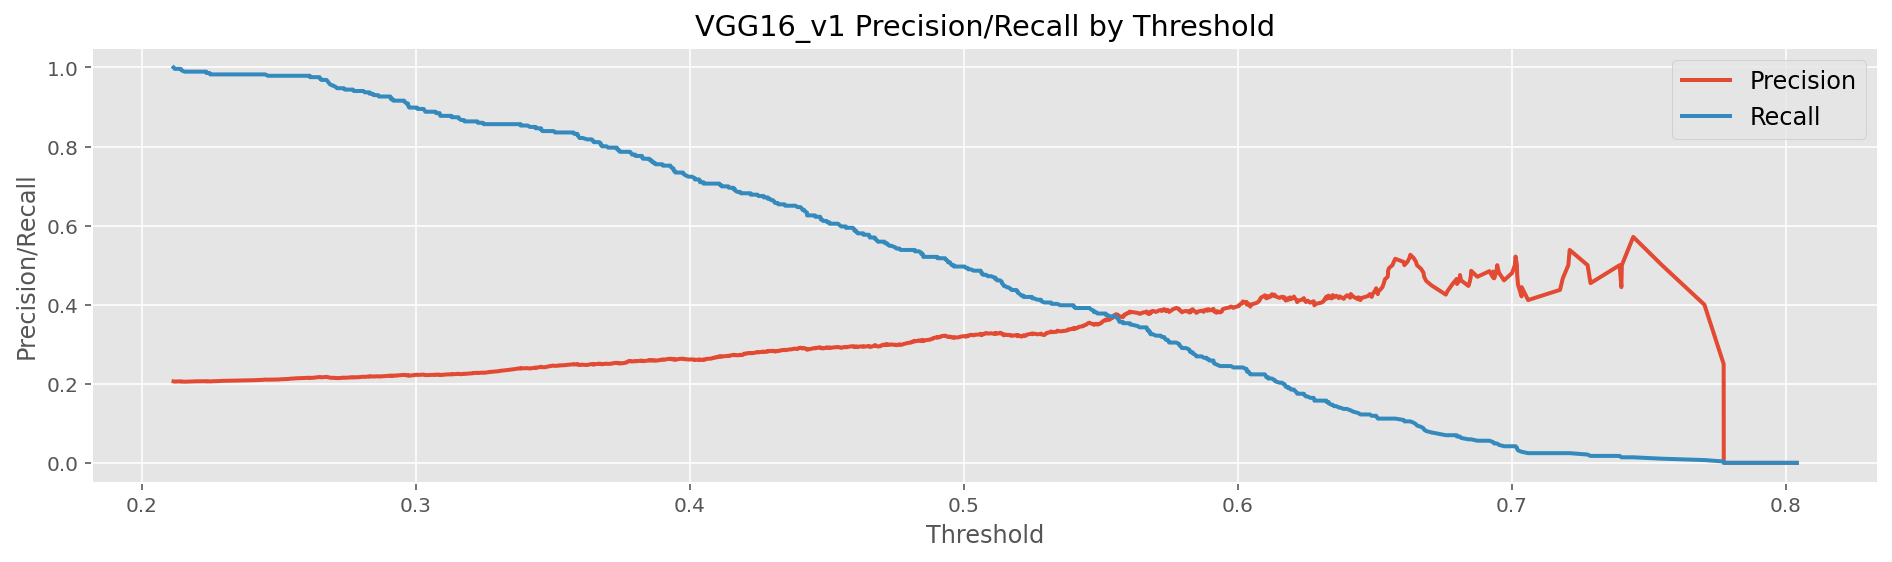

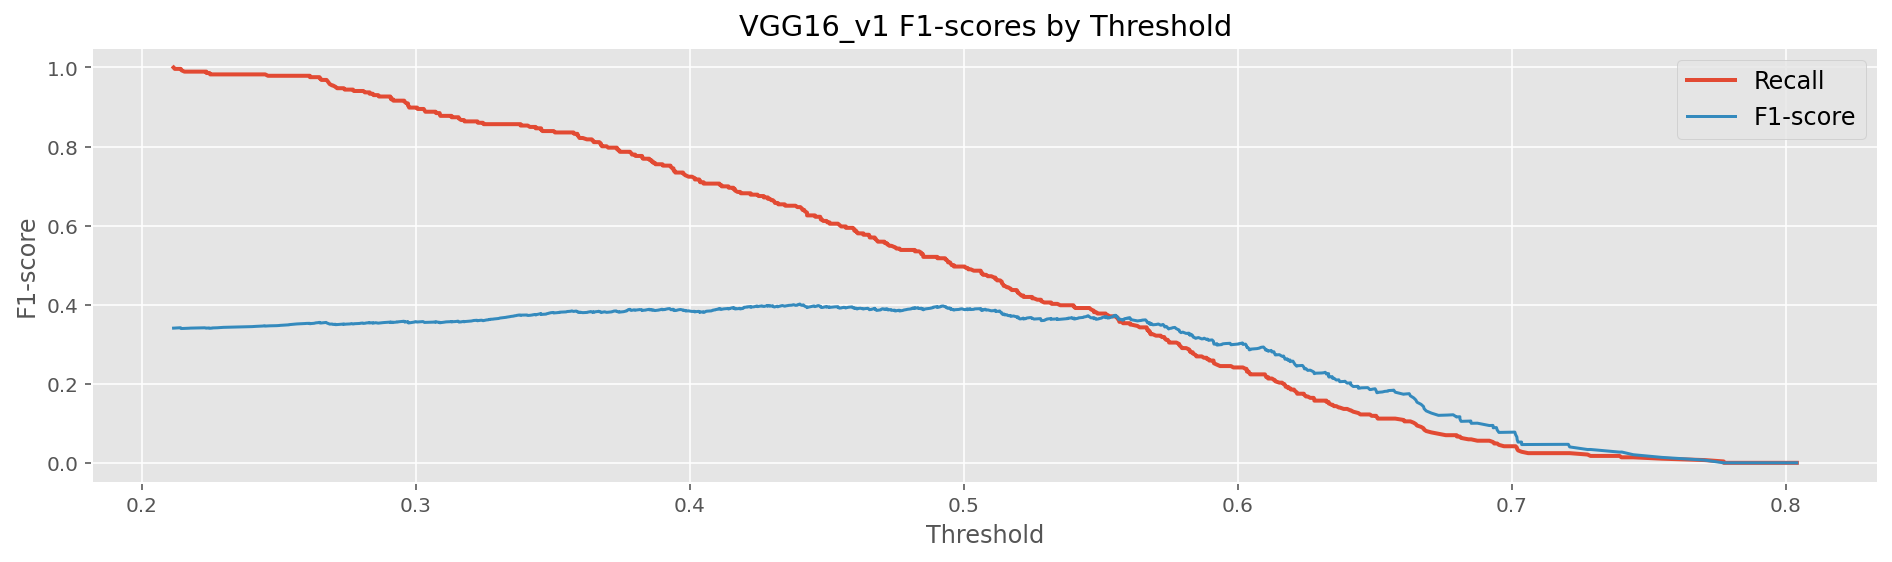

In [61]:
## Plot all figures.
plot_history(vgg_model_v1, history)
plot_auc(vgg_model_v1, valY, pred_Y)
plot_f1_scores(vgg_model_v1, valY, pred_Y)
plot_prec_recall(vgg_model_v1, valY, pred_Y)
plot_prec_recall_by_threshold(vgg_model_v1, valY, pred_Y)
plot_f1_recall_by_threshold(vgg_model_v1, valY, pred_Y)

In [62]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

# Compute, and return the F1-score.
def f1(threshold):

    for i, t in enumerate(thresholds):
        if t > threshold:
            f1_sc = calc_f1_score(precision[i], recall[i])
            if not math.isnan(f1_sc):
                return f1_sc
            else: 
                return 0
    return 0

f1_scores = [f1(t) for t in thresholds]
idx = np.argmax(np.array(f1_scores, dtype=np.float32))
f1 = f1_scores[idx]

print(f'Best/Max F1-score: {f1: .4f}\nThreshold at MAX F1-score: {thresholds[idx]: .4f}\nPecision: {precision[idx]: .4f}\nRecall: {recall[idx]: .4f}')

Best/Max F1-score:  0.4017
Threshold at MAX F1-score:  0.4402
Pecision:  0.2909
Recall:  0.6469


In [63]:
## Get the index at a given threshold.
def get_idx(threshold):
    
    for idx, t in enumerate(thresholds):
        if t > threshold:
            return idx

print(f'Precision: {precision[get_idx(.29)]: .3f}, Recall: {recall[get_idx(.29)]: .3f}, F1-score: {f1_scores[get_idx(.29)]: .3f}, Threshold: {thresholds[get_idx(.29)]: .3f}')
print(f'Precision: {precision[get_idx(.3)]: .3f}, Recall: {recall[get_idx(.3)]: .3f}, F1-score: {f1_scores[get_idx(.3)]: .3f}, Threshold: {thresholds[get_idx(.3)]: .3f}')
print(f'Precision: {precision[get_idx(.31)]: .3f}, Recall: {recall[get_idx(.31)]: .3f}, F1-score: {f1_scores[get_idx(.31)]: .3f}, Threshold: {thresholds[get_idx(.31)]: .3f}')
print(f'Precision: {precision[get_idx(.35)]: .3f}, Recall: {recall[get_idx(.35)]: .3f}, F1-score: {f1_scores[get_idx(.35)]: .3f}, Threshold: {thresholds[get_idx(.35)]: .3f}')

Precision:  0.220, Recall:  0.927, F1-score:  0.355, Threshold:  0.290
Precision:  0.223, Recall:  0.899, F1-score:  0.357, Threshold:  0.300
Precision:  0.223, Recall:  0.878, F1-score:  0.356, Threshold:  0.310
Precision:  0.246, Recall:  0.839, F1-score:  0.380, Threshold:  0.350


In [64]:
def log_confusion_matrix_results():
    
    tn, fp, fn, tp = confusion_matrix(valY, (pred_Y > .3).astype(int)).ravel()
    print(f'True Negatives: {tn: .0f}')
    print(f'False Positives: {fp: .0f}')
    print(f'False Negatives: {fn: .0f}')
    print(f'True Positives: {tp: .0f}')
    
log_confusion_matrix_results()

True Negatives:  247
False Positives:  897
False Negatives:  29
True Positives:  257


In [65]:
## Just save model architecture to a .json:
def save_model_architecture(model):
    
    model_json = model.to_json()
    with open("./out/{}.json".format(model.name), "w") as json_file:
        json_file.write(model_json)
    return

In [66]:
## Save model architecture.
save_model_architecture(model=vgg_model_v1)

### Feedback

- **Model 1**’s architecture doesn’t seem to be promising since its accuracy is scored at a little over sixty percent (exactly 62.23%).
- As we look at the graphs (especially both accuracy and loss evolutions) we see that the performance is clearly unstable (with little learning after the training cycle).
- At this stage one might consider adding **Dropouts** and **Fully Connected (FC)** layers to the model and see if this update to the architecture might yield promising results, when compared to the outputs revealed above.

## Model 2 (VGG16_v2)

### About

- Like **Model 1**, **Model 2**'s architecture uses the last output layer from the downloaded **VGG16** pretrained model. However, the difference here is in the addition of one dropout layer to the model (i.e., by specifying `fc_list=[1024]`), consequently including one FC-layer into the model architecture since the length of the list is 1 (see the definition of ` build(**vargs)` for details).
- Like **Model 1**, **Model 2** is assumed to run for 15 epochs to observe the learning outcomes.
- Due to a **VRAM** limitation currently present in the working computer, the `BATCH_SIZE` hyperparameter was reduced to just 8 – to avoid OOM errors witnessed during the initial training sessions of the model. GPU’s VRAM is 10 GB for reference.

In [67]:
vgg_model_v2 = build(
    name="VGG16_v2",
    end_layer_freeze_at=-1,
    specific_layer=None,
    fc_list=[512])

VGG16 Layers:
input_3: Trainable? True
block1_conv1: Trainable? True
block1_conv2: Trainable? True
block1_pool: Trainable? True
block2_conv1: Trainable? True
block2_conv2: Trainable? True
block2_pool: Trainable? True
block3_conv1: Trainable? True
block3_conv2: Trainable? True
block3_conv3: Trainable? True
block3_pool: Trainable? True
block4_conv1: Trainable? True
block4_conv2: Trainable? True
block4_conv3: Trainable? True
block4_pool: Trainable? True
block5_conv1: Trainable? True
block5_conv2: Trainable? True
block5_conv3: Trainable? True
block5_pool: Trainable? True


In [68]:
vgg_model_v2.summary()

Model: "VGG16_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 27,560,769
Trainable params: 12,846,081
Non-

In [69]:
weight_path, callbacks_list = add_checkpoints(model=vgg_model_v2)

In [70]:
## train your model.
history = vgg_model_v2.fit_generator(
    train_gen, 
    validation_data=(valX, valY), 
    epochs=NUM_EPOCHS,
    callbacks=callbacks_list)

Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 0.8403 - binary_accuracy: 0.5218
Epoch 00001: val_loss improved from inf to 0.67057, saving model to ./out\xray_classification_VGG16_v2.best.hdf5
72/72 [==============================] - 34s 465ms/step - loss: 0.8403 - binary_accuracy: 0.5218 - val_loss: 0.6706 - val_binary_accuracy: 0.5769
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 0.7089 - binary_accuracy: 0.5546
Epoch 00002: val_loss improved from 0.67057 to 0.59773, saving model to ./out\xray_classification_VGG16_v2.best.hdf5
72/72 [==============================] - 34s 471ms/step - loss: 0.7089 - binary_accuracy: 0.5546 - val_loss: 0.5977 - val_binary_accuracy: 0.7720
Epoch 3/10
72/72 [==============================] - ETA: 0s - loss: 0.6903 - binary_accuracy: 0.5581
Epoch 00003: val_loss did not improve from 0.59773
72/72 [==============================] - 34s 467ms/step - loss: 0.6903 - binary_accuracy: 0.5581 - val_loss: 0.7749 - val_bi

In [71]:
evaluation = vgg_model_v2.evaluate(train_gen)

print(f"Train loss: {evaluation[0] * 100:.2f}%")
print(f"Train accuracy: {evaluation[1] * 100:.2f}%")

72/72 [==============================] - 32s 447ms/step - loss: 0.6600 - binary_accuracy: 0.6000
Train loss: 66.00%
Train accuracy: 60.00%


After training, wel look at the performance of this model by plotting some performance statistics.

Again, these figures will come in handy for the FDA documentation later in the project.

In [72]:
history_df = pd.DataFrame(history.history)

performance.append(history_df[history_df['val_loss']==min(history_df['val_loss'])])
performance

[       loss  binary_accuracy  val_loss  val_binary_accuracy
 6  0.676528         0.603493  0.598863             0.688811,
        loss  binary_accuracy  val_loss  val_binary_accuracy
 3  0.676711         0.585153  0.564058             0.758042]

In [73]:
## After training, make some predictions to assess your model's overall performance.
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
vgg_model_v2.load_weights(weight_path)
pred_Y = vgg_model_v2.predict(valX, batch_size=BATCH_SIZE, verbose=True)

45/45 [==============================] - 1s 29ms/step


In [74]:
pred_Y.shape

(1430, 1)

In [75]:
save_history_df_to_file(vgg_model_v2)

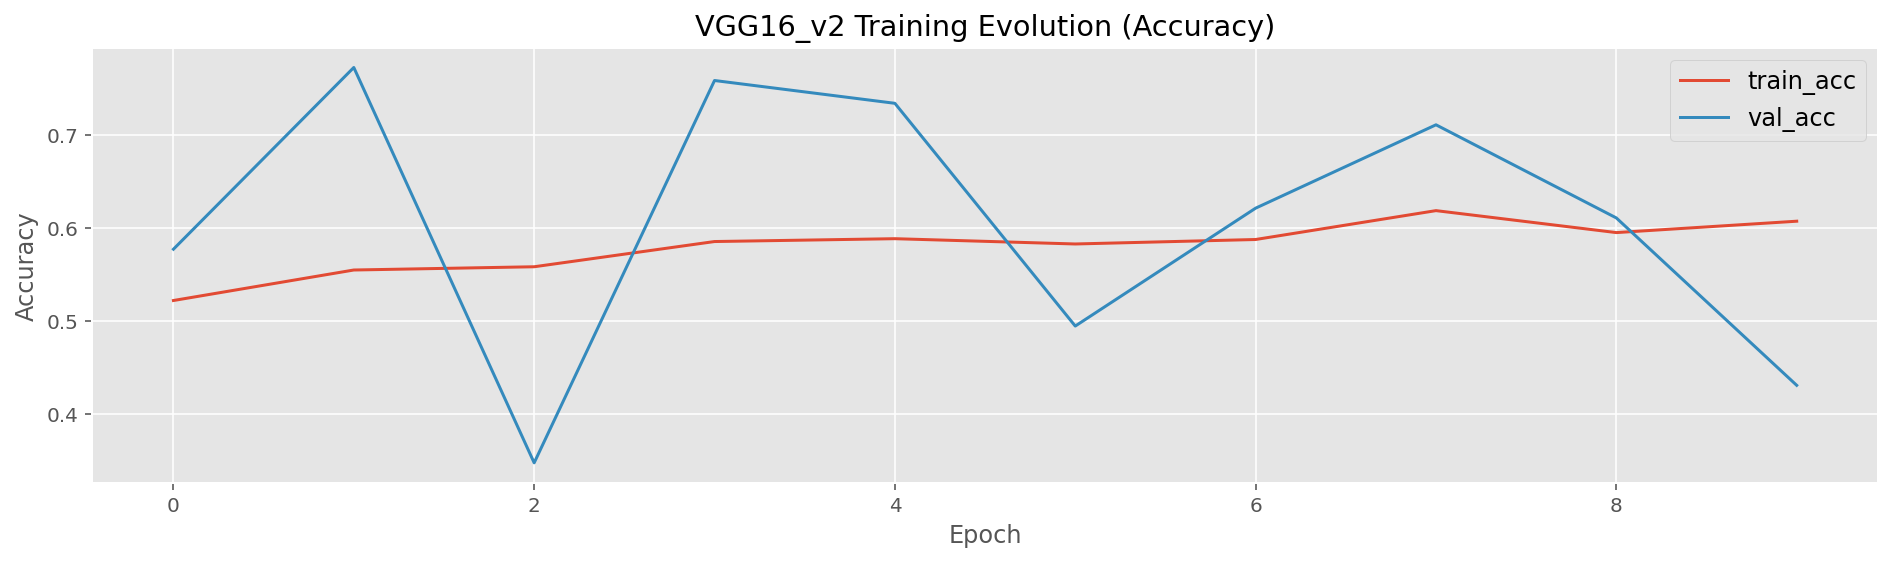

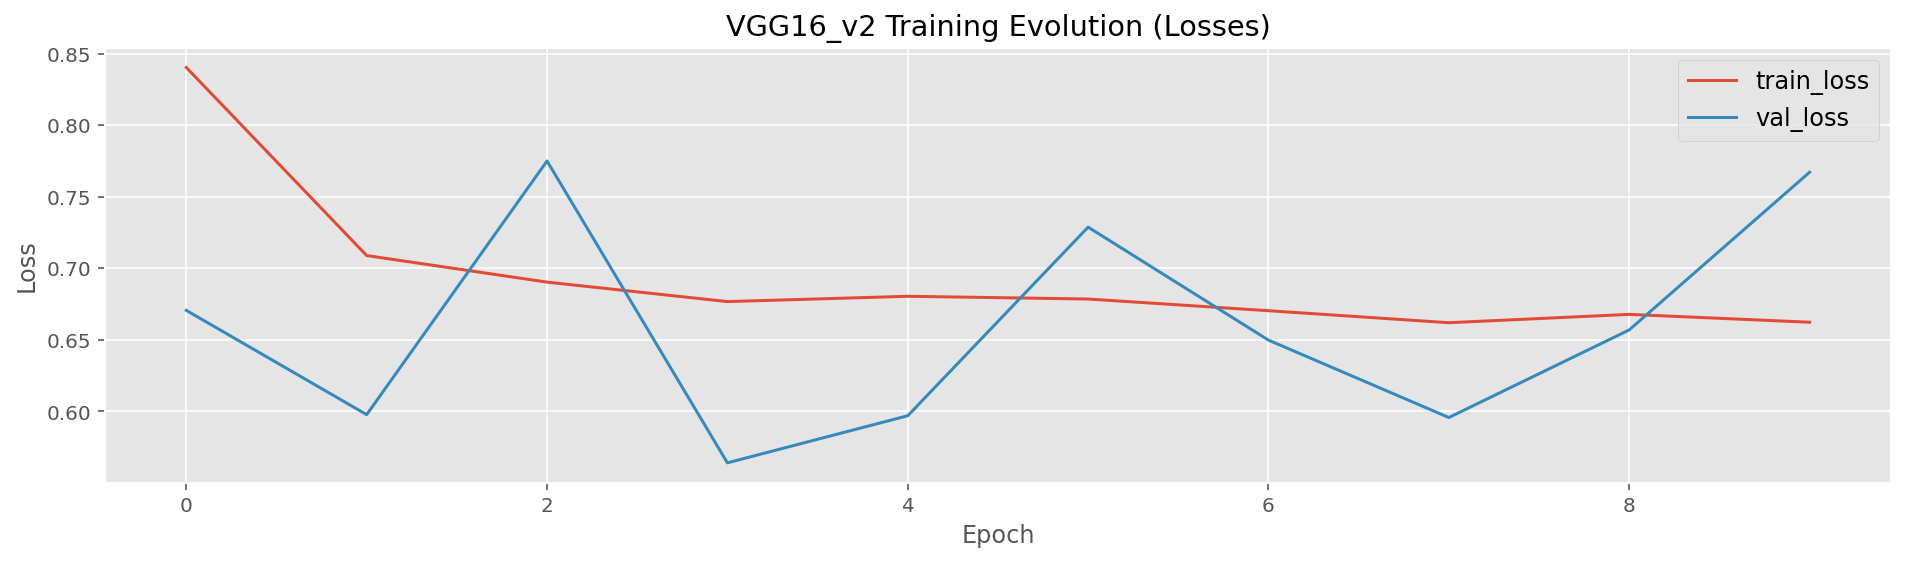

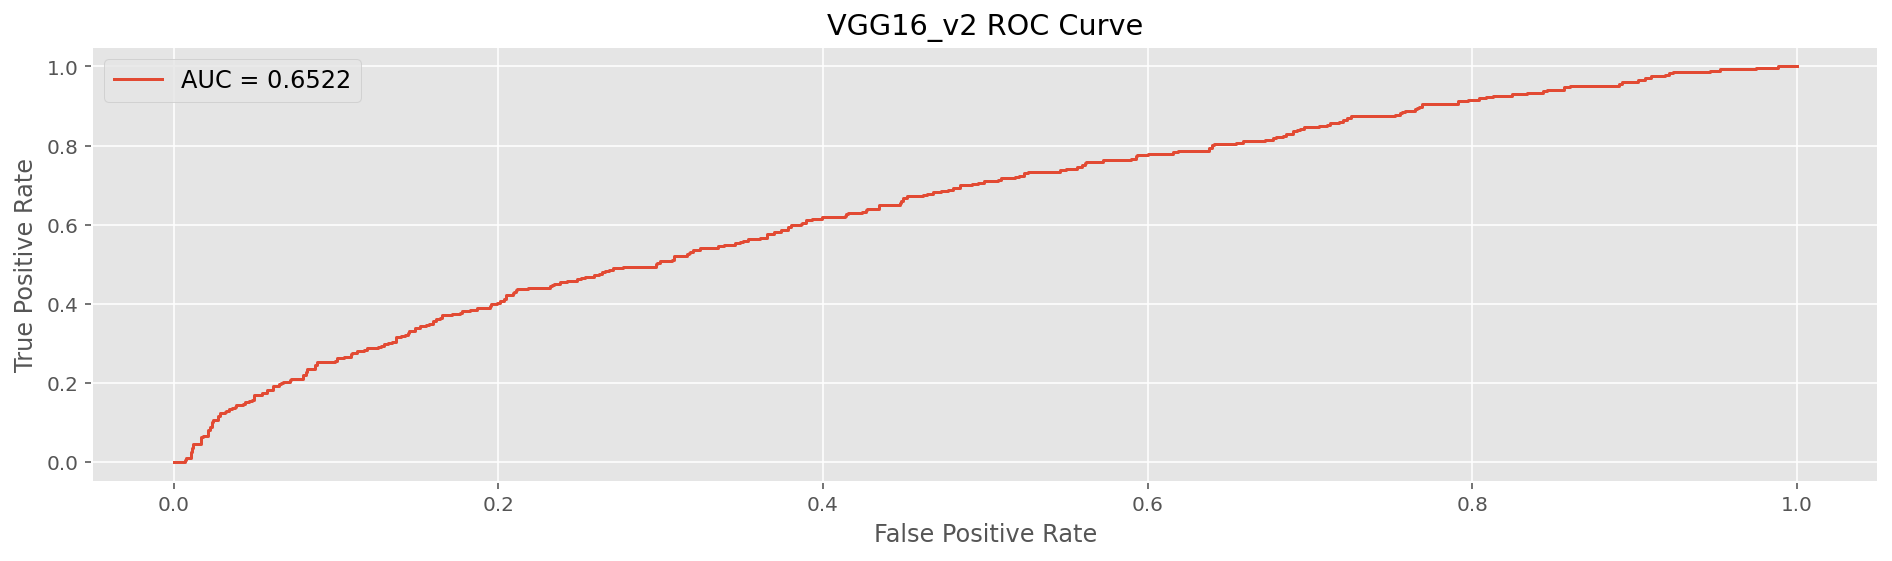

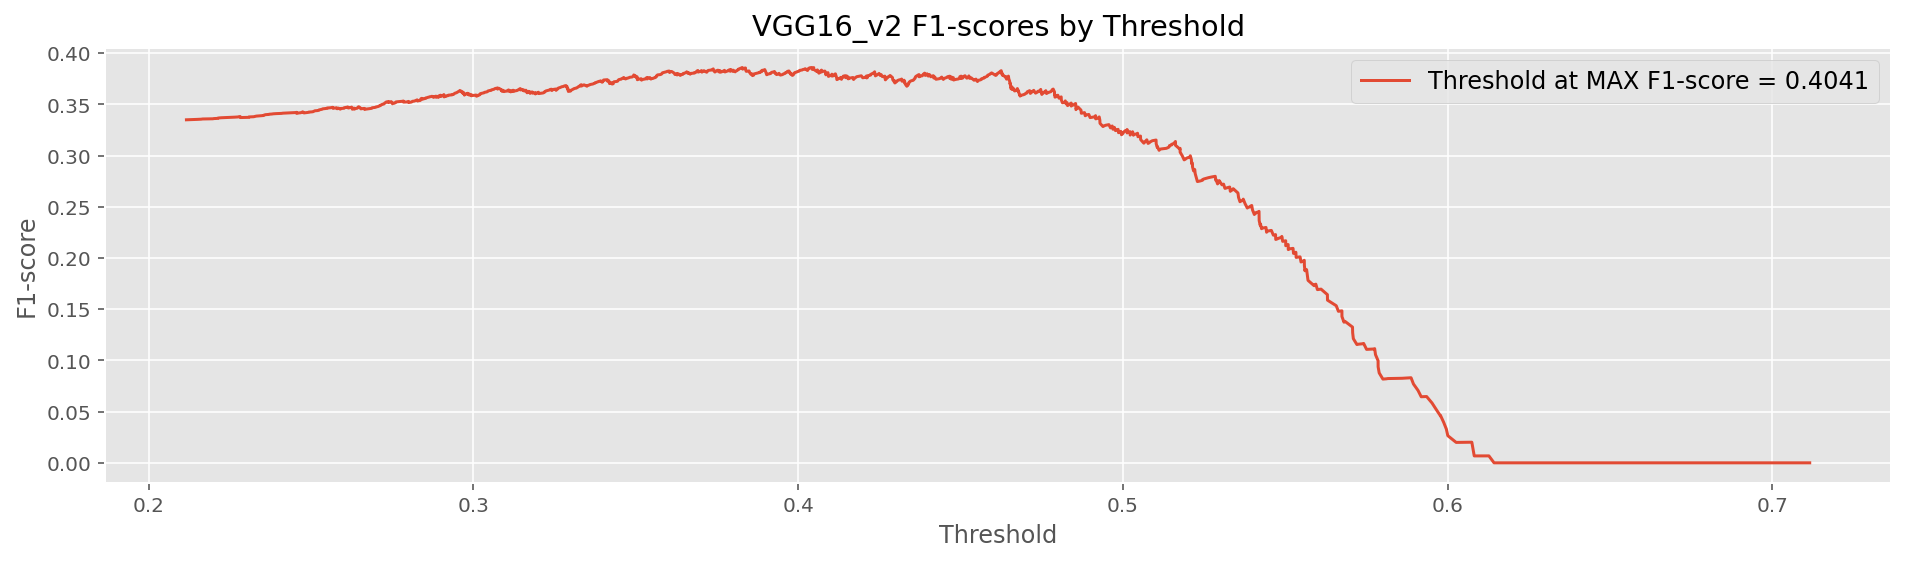

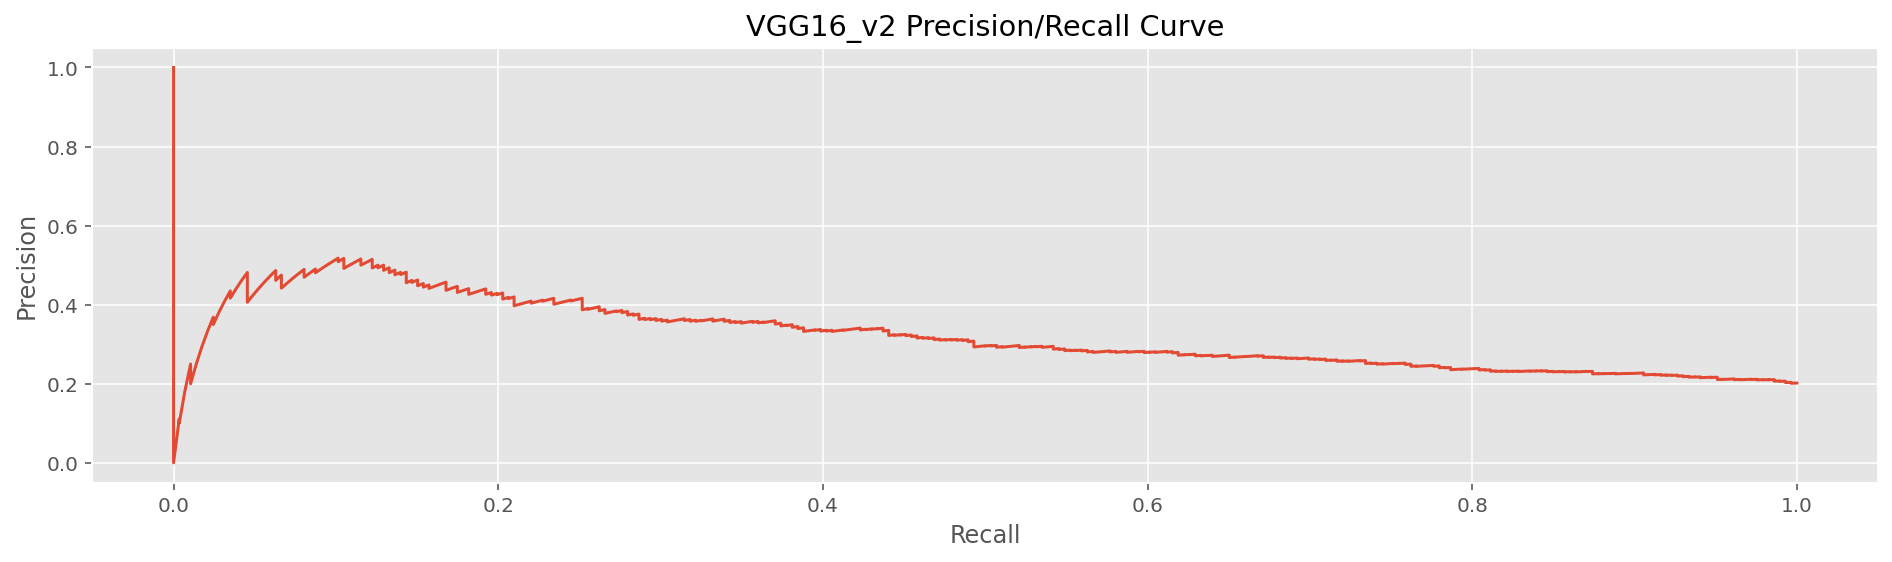

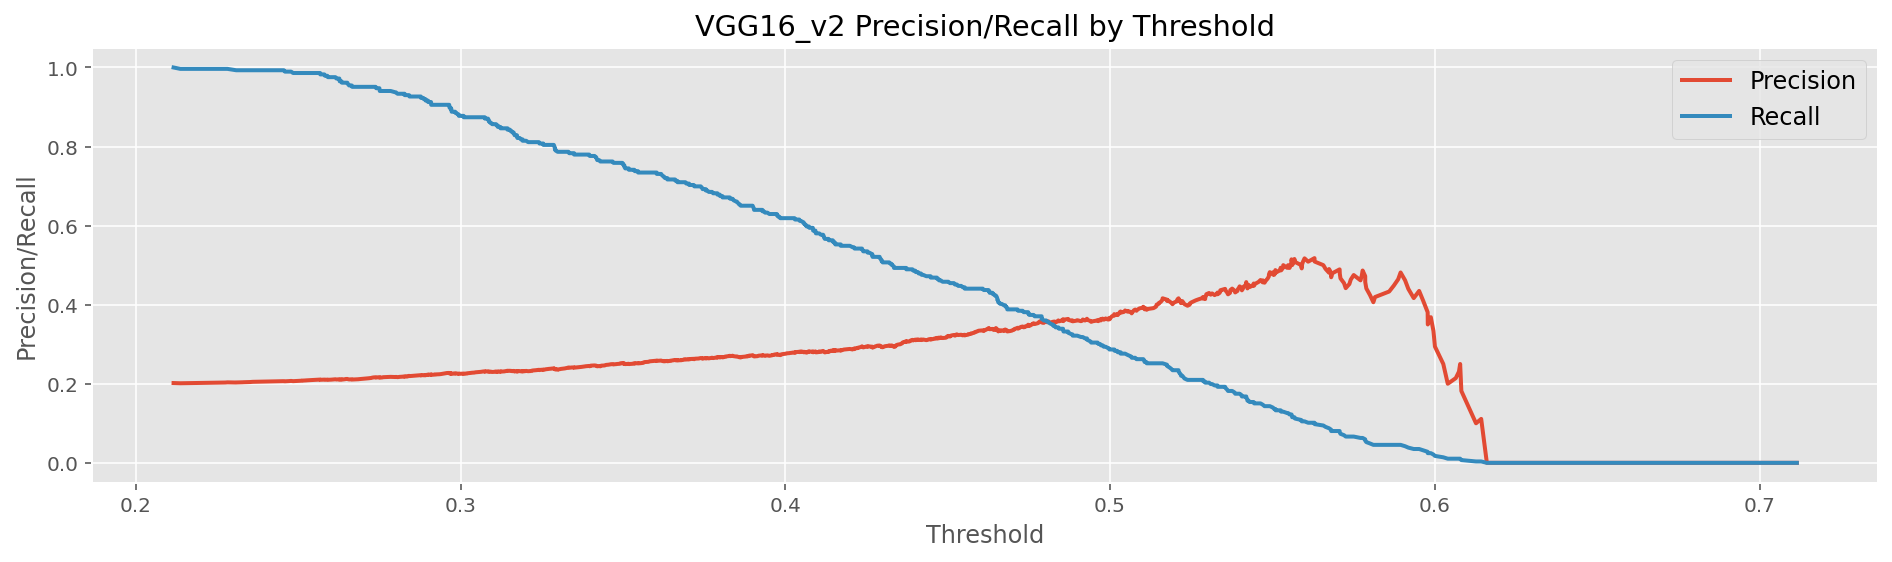

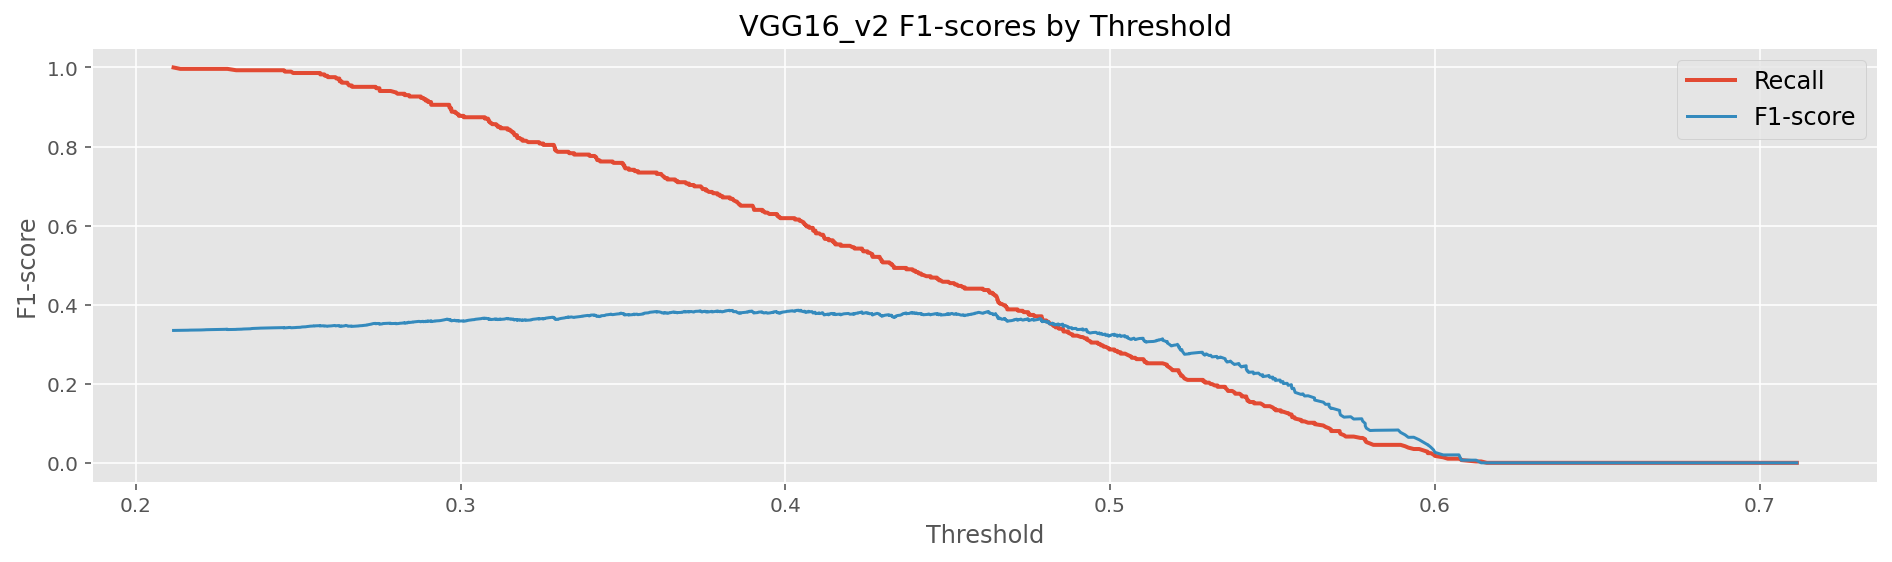

In [76]:
## Plot all figures.
plot_history(vgg_model_v2, history)
plot_auc(vgg_model_v2, valY, pred_Y)
plot_f1_scores(vgg_model_v2, valY, pred_Y)
plot_prec_recall(vgg_model_v2, valY, pred_Y)
plot_prec_recall_by_threshold(vgg_model_v2, valY, pred_Y)
plot_f1_recall_by_threshold(vgg_model_v2, valY, pred_Y)

In [77]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

# Compute, and return the F1-score.
def f1(threshold):

    for i, t in enumerate(thresholds):
        if t > threshold:
            f1_sc = calc_f1_score(precision[i], recall[i])
            if not math.isnan(f1_sc):
                return f1_sc
            else: 
                return 0
    return 0

f1_scores = [f1(t) for t in thresholds]
idx = np.argmax(np.array(f1_scores, dtype=np.float32))
f1 = f1_scores[idx]

print(f'Best/Max F1-score: {f1: .4f}\nThreshold at MAX F1-score: {thresholds[idx]: .4f}\nPecision: {precision[idx]: .4f}\nRecall: {recall[idx]: .4f}')

Best/Max F1-score:  0.3860
Threshold at MAX F1-score:  0.4041
Pecision:  0.2807
Recall:  0.6154


In [78]:
print(f'Precision: {precision[get_idx(.29)]: .3f}, Recall: {recall[get_idx(.29)]: .3f}, F1-score: {f1_scores[get_idx(.29)]: .3f}, Threshold: {thresholds[get_idx(.29)]: .3f}')
print(f'Precision: {precision[get_idx(.3)]: .3f}, Recall: {recall[get_idx(.3)]: .3f}, F1-score: {f1_scores[get_idx(.3)]: .3f}, Threshold: {thresholds[get_idx(.3)]: .3f}')
print(f'Precision: {precision[get_idx(.31)]: .3f}, Recall: {recall[get_idx(.31)]: .3f}, F1-score: {f1_scores[get_idx(.31)]: .3f}, Threshold: {thresholds[get_idx(.31)]: .3f}')
print(f'Precision: {precision[get_idx(.35)]: .3f}, Recall: {recall[get_idx(.35)]: .3f}, F1-score: {f1_scores[get_idx(.35)]: .3f}, Threshold: {thresholds[get_idx(.35)]: .3f}')

Precision:  0.223, Recall:  0.913, F1-score:  0.358, Threshold:  0.290
Precision:  0.225, Recall:  0.878, F1-score:  0.359, Threshold:  0.300
Precision:  0.230, Recall:  0.857, F1-score:  0.363, Threshold:  0.310
Precision:  0.252, Recall:  0.755, F1-score:  0.376, Threshold:  0.350


In [79]:
log_confusion_matrix_results()

True Negatives:  281
False Positives:  863
False Negatives:  35
True Positives:  251


In [80]:
## Save model architecture.
save_model_architecture(model=vgg_model_v2)

### Feedback

- This is an interesting situation here, especially after finding out that the simple update to **Model 1**’s architecture resulted in a *relatively* higher accuracy of 64.72% (which is a small +2.49% delta) for **Model 2**.
- The Accuracy/Loss graphs plotted for **Model 2** showed a steadiness in training evolution over time. Compared to **Model 1**’s plots, **Model 2** seems to be slightly better and has outperformed **Model 1** by a little (yet still not convincing for being a trustworthy model for general use due to being lower than eighty percent in general). Nevertheless, this finding suggests such a modification is indeed promising for further experimentations.
- At this stage one might consider adding more **Dropouts** and **Fully Connected (FC)** layers to the model and see if this update to the architecture might yield promising results, when compared to the outputs revealed above.

In [81]:
## We will find the threshold that optimize this model's performance,
## and use it to make binary classifications later (see below).\

# Precision and Recall are already obtained previously.
BEST_THRESHOLD_MODEL_2 = calc_best_threshold(precision, recall)

print(f'{vgg_model_v2.name}\'s best/max threshold: {BEST_THRESHOLD_MODEL_2: .4f}')

Threshold that maximized the F1-score: 0.4043
Corresponding Precision: 0.28
Recall: 0.62
VGG16_v2's best/max threshold:  0.4043


In [82]:
## Saved for later use:
pred_Y_vgg_model_v2 = pred_Y

## Model 3 (VGG16_v3)

### About

- Like **Model 2**, **Model 3**'s architecture uses the last output layer from the downloaded **VGG16** pretrained model. However, the difference here is in the addition of four dropout layers to the model (i.e., by specifying `fc_list=[1024, 512, 256, 128]`), consequently including foru FC-layers into the model architecture since the length of the list is 4 (see the definition of ` build(**vargs)` for details).
- Like **Model 2**, **Model 3** is assumed to run for 15 epochs to observe the learning outcomes.
- Due to a **VRAM** limitation currently present in the working computer, the `BATCH_SIZE` hyperparameter was reduced to just 8 – to avoid OOM errors witnessed during the initial training sessions of the model. GPU’s VRAM is 10 GB for reference.

In [83]:
vgg_model_v3 = build(
    name="VGG16_v3",
    end_layer_freeze_at=-1,
    specific_layer=None,
    fc_list=[512, 256, 128, 64])

VGG16 Layers:
input_4: Trainable? True
block1_conv1: Trainable? True
block1_conv2: Trainable? True
block1_pool: Trainable? True
block2_conv1: Trainable? True
block2_conv2: Trainable? True
block2_pool: Trainable? True
block3_conv1: Trainable? True
block3_conv2: Trainable? True
block3_conv3: Trainable? True
block3_pool: Trainable? True
block4_conv1: Trainable? True
block4_conv2: Trainable? True
block4_conv3: Trainable? True
block4_pool: Trainable? True
block5_conv1: Trainable? True
block5_conv2: Trainable? True
block5_conv3: Trainable? True
block5_pool: Trainable? True


In [84]:
vgg_model_v3.summary()

Model: "VGG16_v3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0  

In [85]:
weight_path, callbacks_list = add_checkpoints(model=vgg_model_v3)

In [86]:
## train your model.
history = vgg_model_v3.fit_generator(
    train_gen, 
    validation_data=(valX, valY), 
    epochs=NUM_EPOCHS,
    callbacks=callbacks_list)

Epoch 1/10
72/72 [==============================] - ETA: 0s - loss: 0.9192 - binary_accuracy: 0.5048
Epoch 00001: val_loss improved from inf to 0.66403, saving model to ./out\xray_classification_VGG16_v3.best.hdf5
72/72 [==============================] - 35s 473ms/step - loss: 0.9192 - binary_accuracy: 0.5048 - val_loss: 0.6640 - val_binary_accuracy: 0.7993
Epoch 2/10
72/72 [==============================] - ETA: 0s - loss: 0.8007 - binary_accuracy: 0.5079
Epoch 00002: val_loss did not improve from 0.66403
72/72 [==============================] - 34s 467ms/step - loss: 0.8007 - binary_accuracy: 0.5079 - val_loss: 0.6869 - val_binary_accuracy: 0.6573
Epoch 3/10
72/72 [==============================] - ETA: 0s - loss: 0.7622 - binary_accuracy: 0.5148
Epoch 00003: val_loss did not improve from 0.66403
72/72 [==============================] - 34s 468ms/step - loss: 0.7622 - binary_accuracy: 0.5148 - val_loss: 0.6661 - val_binary_accuracy: 0.7944
Epoch 4/10
72/72 [==========================

In [87]:
evaluation = vgg_model_v3.evaluate(train_gen)

print(f"Train loss: {evaluation[0] * 100:.2f}%")
print(f"Train accuracy: {evaluation[1] * 100:.2f}%")

72/72 [==============================] - 32s 437ms/step - loss: 0.6929 - binary_accuracy: 0.5079
Train loss: 69.29%
Train accuracy: 50.79%


After training, wel look at the performance of this model by plotting some performance statistics.

Again, these figures will come in handy for the FDA documentation later in the project.

In [88]:
history_df = pd.DataFrame(history.history)

performance.append(history_df[history_df['val_loss']==min(history_df['val_loss'])])
performance

[       loss  binary_accuracy  val_loss  val_binary_accuracy
 6  0.676528         0.603493  0.598863             0.688811,
        loss  binary_accuracy  val_loss  val_binary_accuracy
 3  0.676711         0.585153  0.564058             0.758042,
        loss  binary_accuracy  val_loss  val_binary_accuracy
 0  0.919196         0.504803  0.664026             0.799301]

In [89]:
## After training, make some predictions to assess your model's overall performance.
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
vgg_model_v3.load_weights(weight_path)
pred_Y = vgg_model_v3.predict(valX, batch_size=BATCH_SIZE, verbose=True)

45/45 [==============================] - 1s 30ms/step


In [90]:
pred_Y.shape

(1430, 1)

In [91]:
save_history_df_to_file(vgg_model_v3)

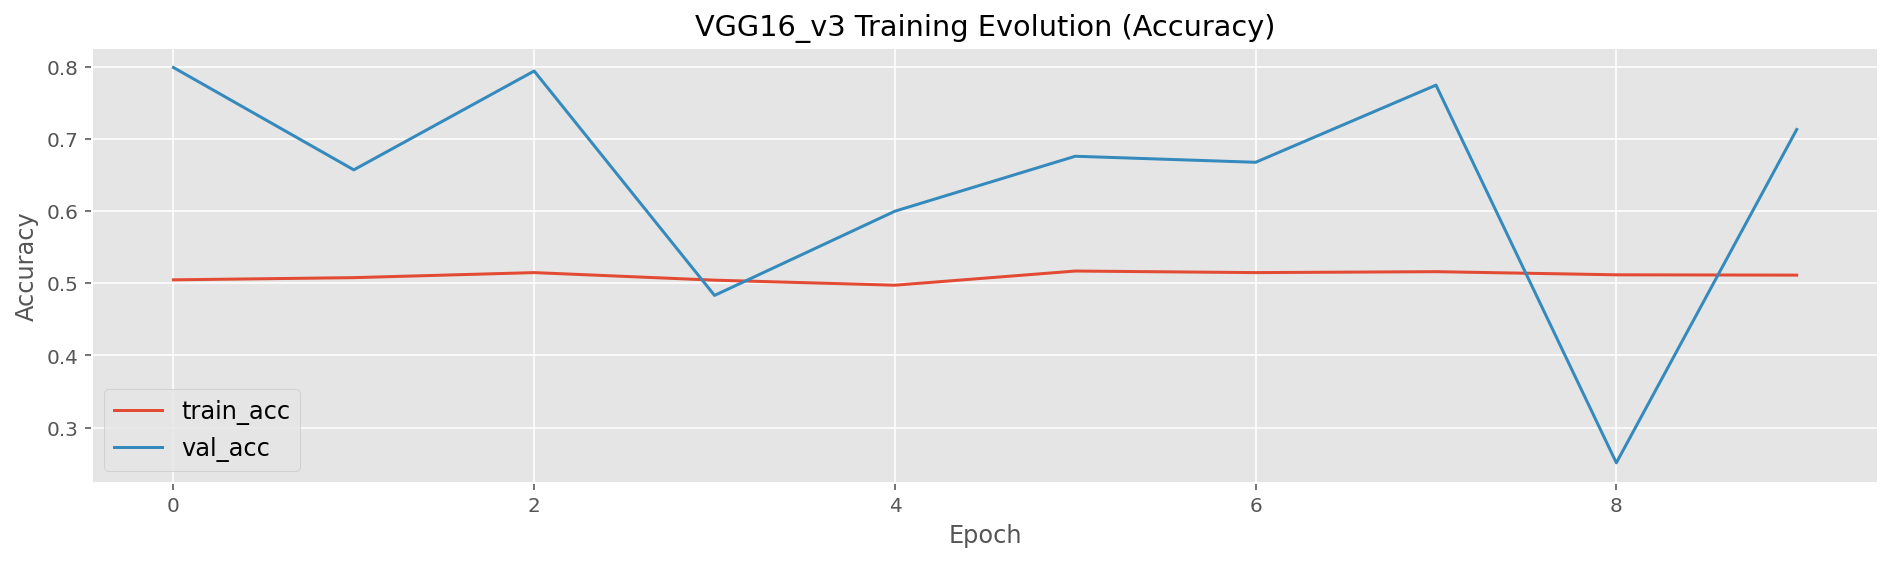

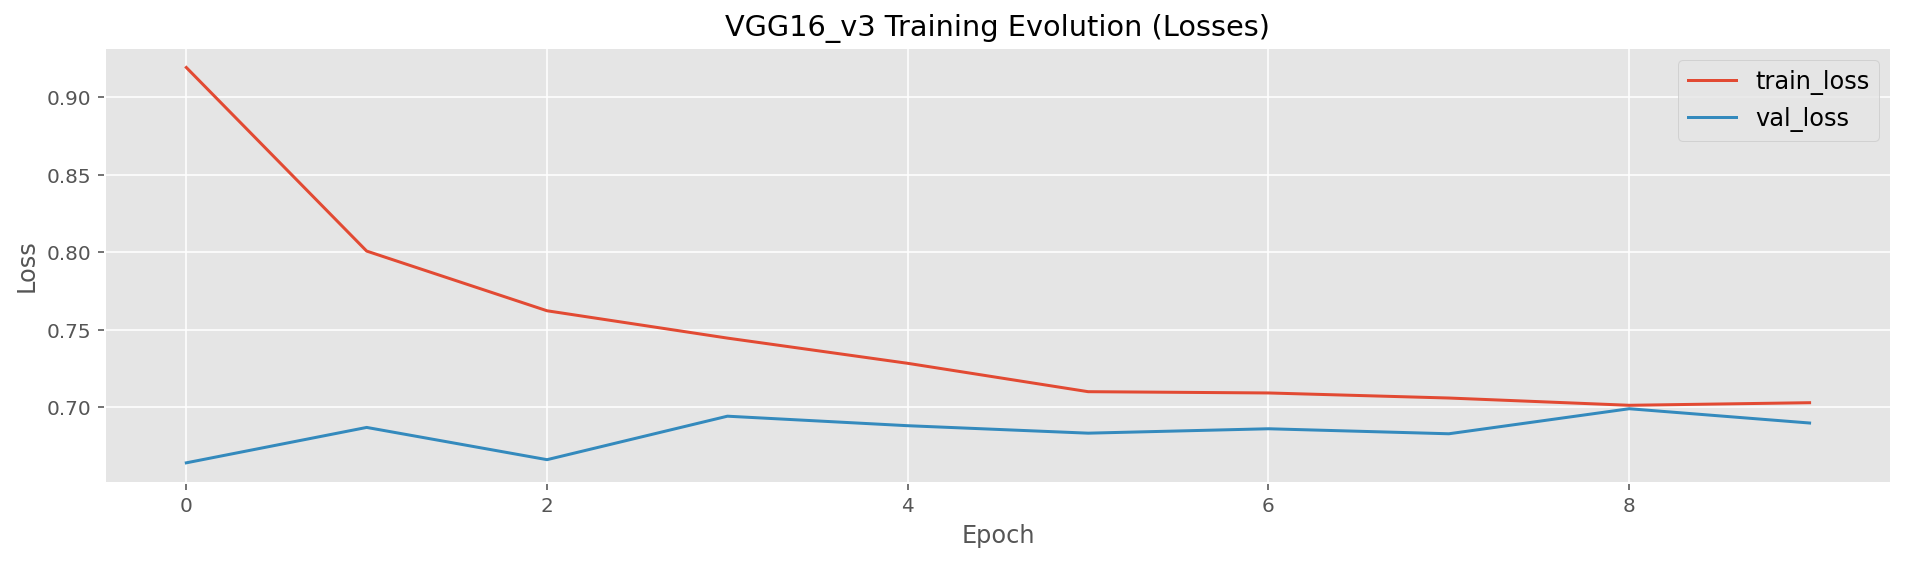

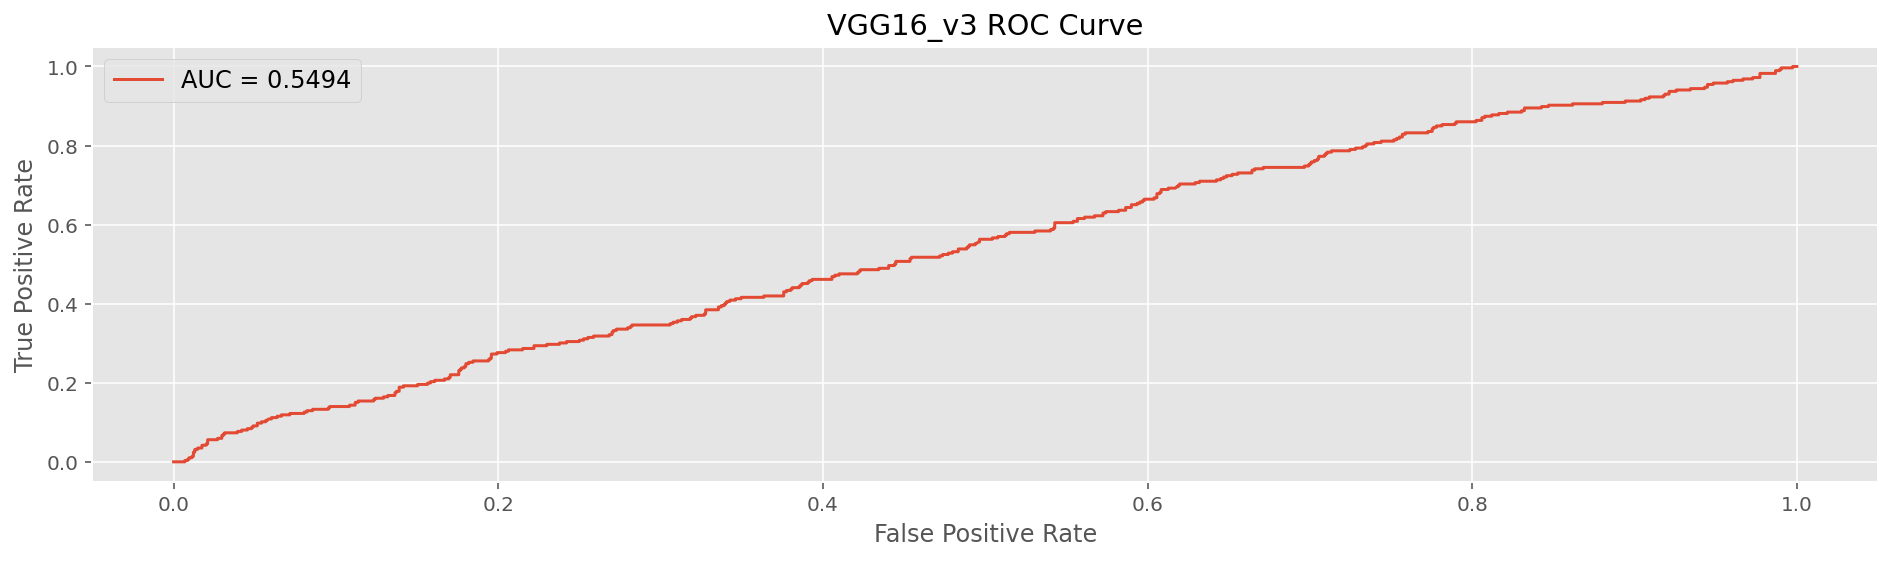

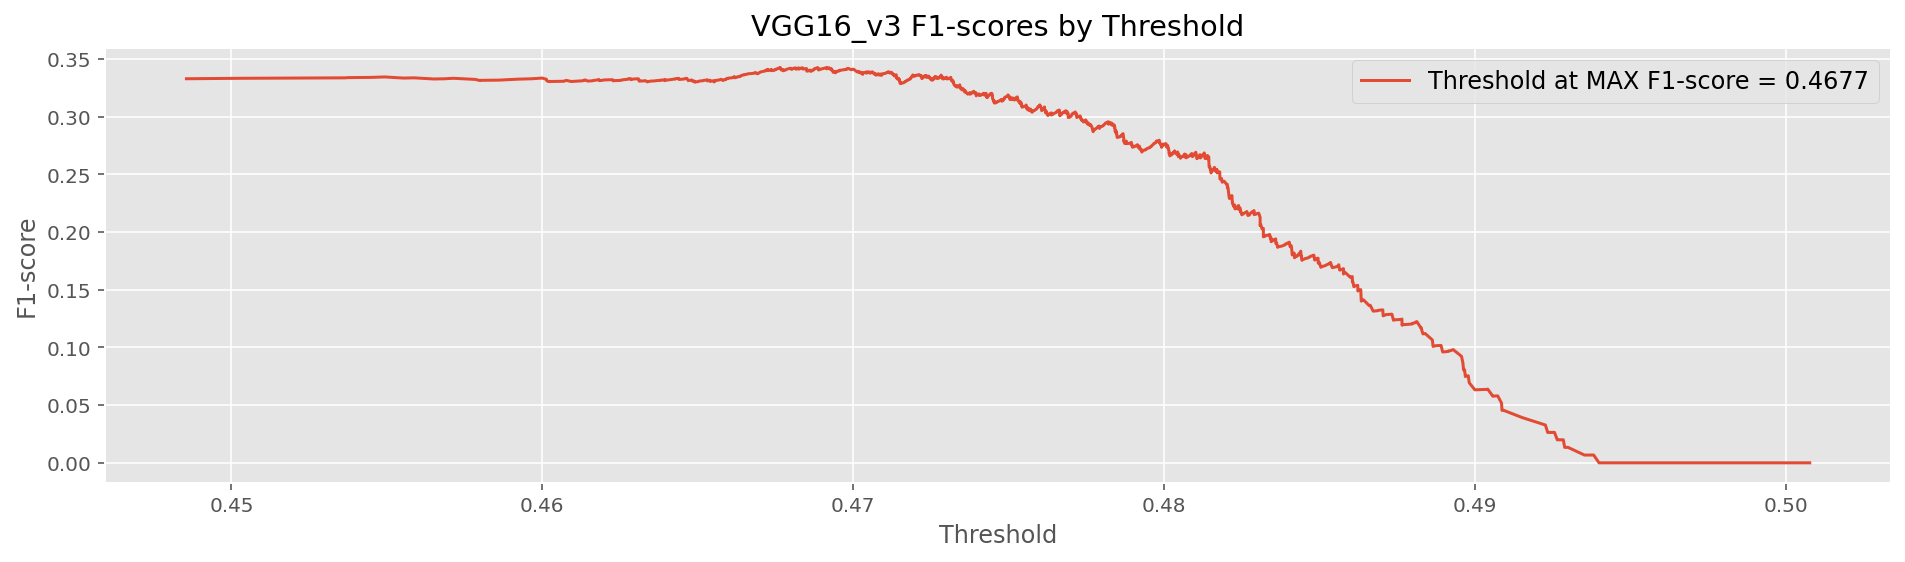

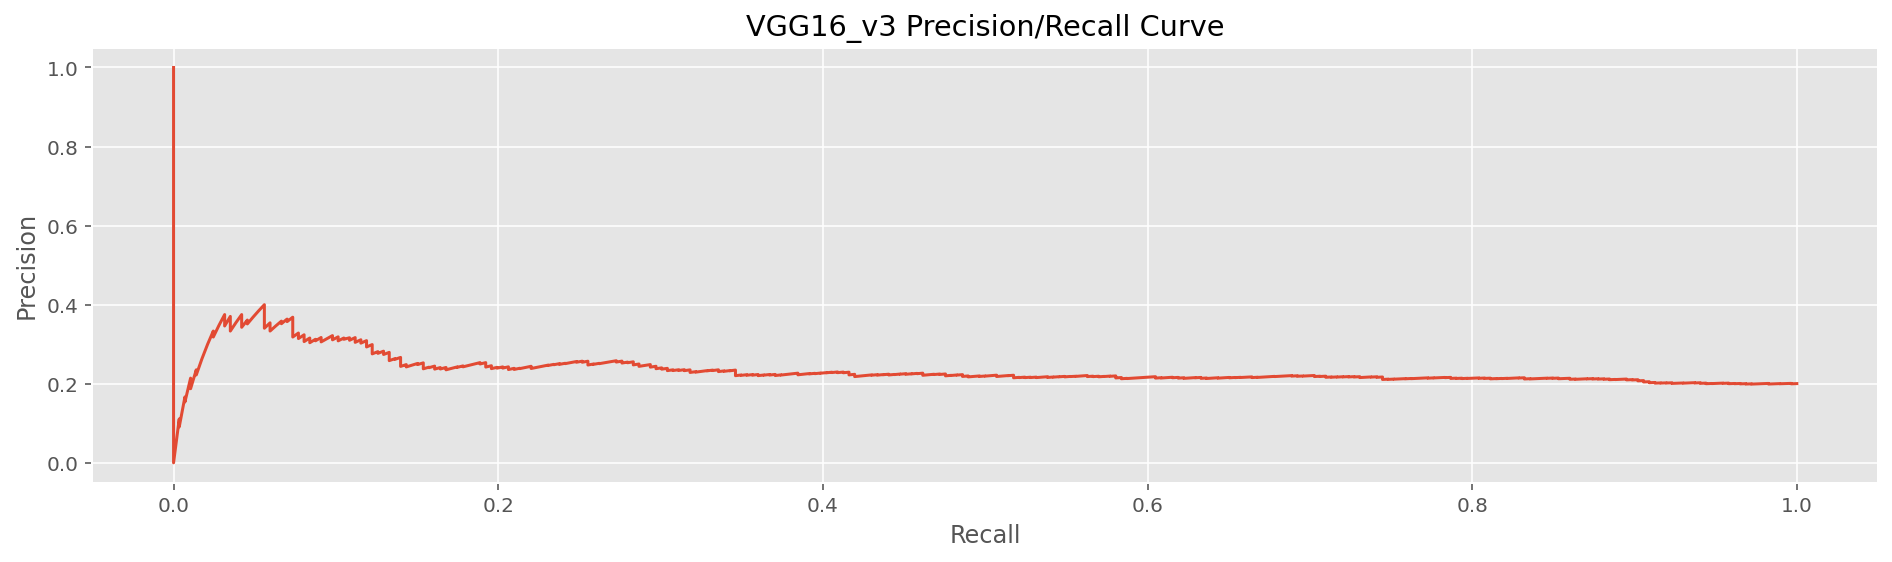

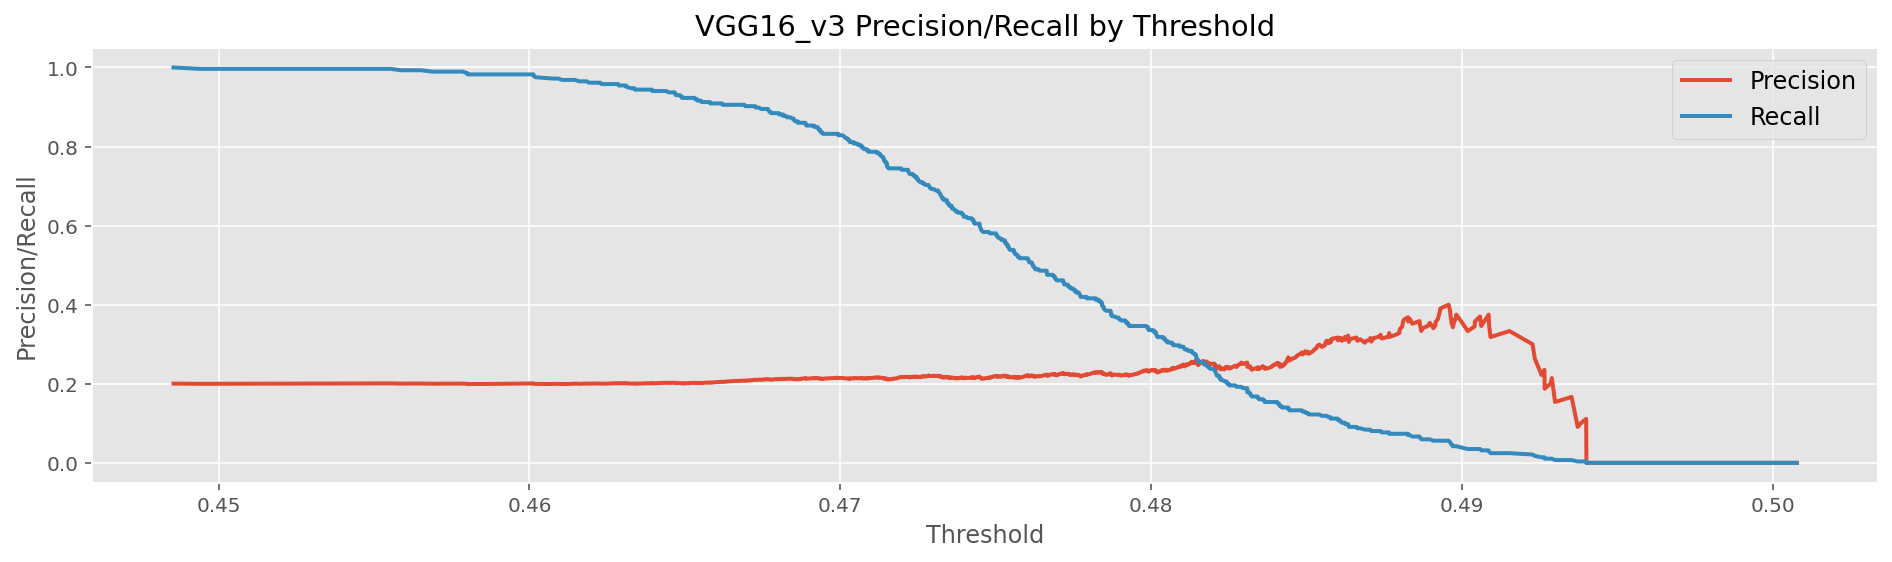

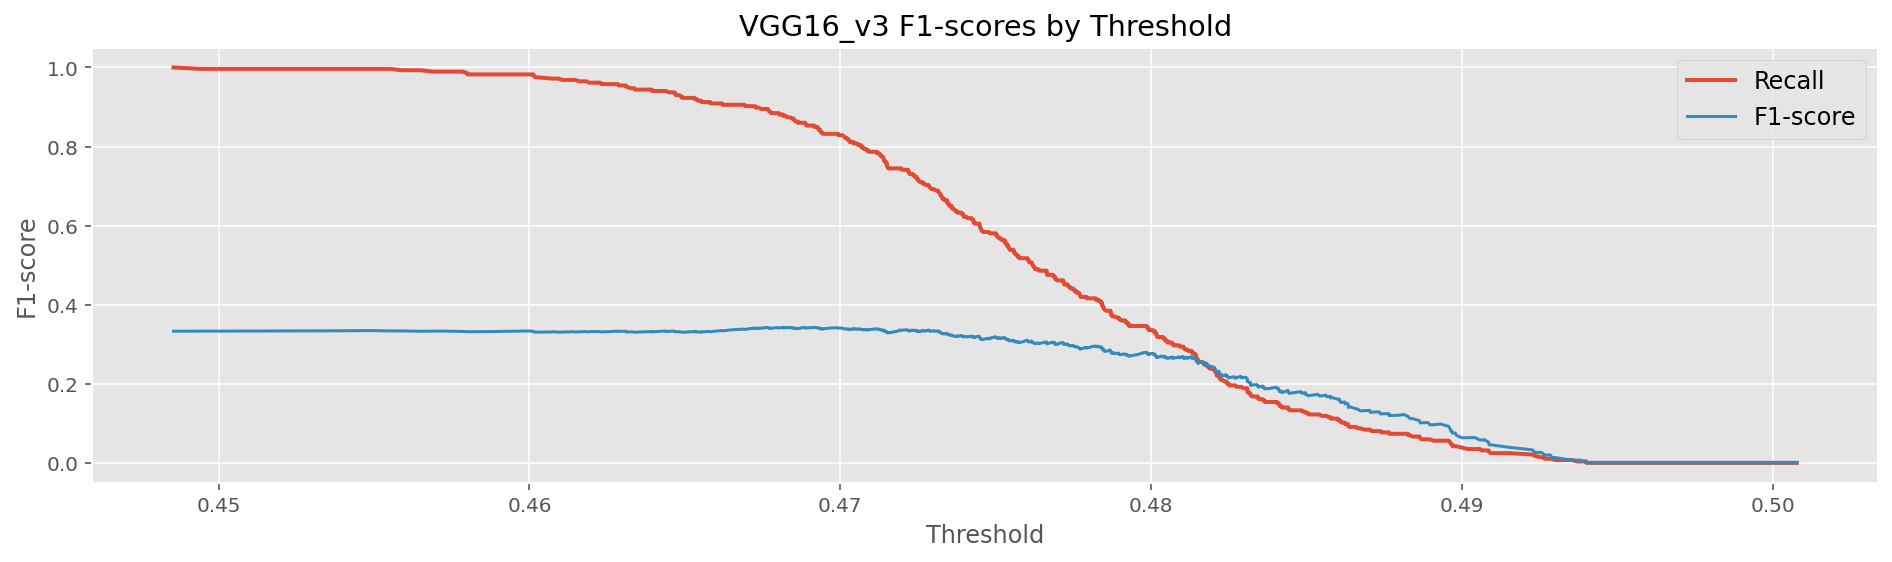

In [92]:
## Plot all figures.
plot_history(vgg_model_v3, history)
plot_auc(vgg_model_v3, valY, pred_Y)
plot_f1_scores(vgg_model_v3, valY, pred_Y)
plot_prec_recall(vgg_model_v3, valY, pred_Y)
plot_prec_recall_by_threshold(vgg_model_v3, valY, pred_Y)
plot_f1_recall_by_threshold(vgg_model_v3, valY, pred_Y)

In [93]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

# Compute, and return the F1-score.
def f1(threshold):

    for i, t in enumerate(thresholds):
        if t > threshold:
            f1_sc = calc_f1_score(precision[i], recall[i])
            if not math.isnan(f1_sc):
                return f1_sc
            else: 
                return 0
    return 0

f1_scores = [f1(t) for t in thresholds]
idx = np.argmax(np.array(f1_scores, dtype=np.float32))
f1 = f1_scores[idx]

print(f'Best/Max F1-score: {f1: .4f}\nThreshold at MAX F1-score: {thresholds[idx]: .4f}\nPecision: {precision[idx]: .4f}\nRecall: {recall[idx]: .4f}')

Best/Max F1-score:  0.3427
Threshold at MAX F1-score:  0.4677
Pecision:  0.2117
Recall:  0.8951


In [94]:
print(f'Precision: {precision[get_idx(.29)]: .3f}, Recall: {recall[get_idx(.29)]: .3f}, F1-score: {f1_scores[get_idx(.29)]: .3f}, Threshold: {thresholds[get_idx(.29)]: .3f}')
print(f'Precision: {precision[get_idx(.3)]: .3f}, Recall: {recall[get_idx(.3)]: .3f}, F1-score: {f1_scores[get_idx(.3)]: .3f}, Threshold: {thresholds[get_idx(.3)]: .3f}')
print(f'Precision: {precision[get_idx(.31)]: .3f}, Recall: {recall[get_idx(.31)]: .3f}, F1-score: {f1_scores[get_idx(.31)]: .3f}, Threshold: {thresholds[get_idx(.31)]: .3f}')
print(f'Precision: {precision[get_idx(.35)]: .3f}, Recall: {recall[get_idx(.35)]: .3f}, F1-score: {f1_scores[get_idx(.35)]: .3f}, Threshold: {thresholds[get_idx(.35)]: .3f}')

Precision:  0.200, Recall:  1.000, F1-score:  0.333, Threshold:  0.449
Precision:  0.200, Recall:  1.000, F1-score:  0.333, Threshold:  0.449
Precision:  0.200, Recall:  1.000, F1-score:  0.333, Threshold:  0.449
Precision:  0.200, Recall:  1.000, F1-score:  0.333, Threshold:  0.449


In [95]:
log_confusion_matrix_results()

True Negatives:  0
False Positives:  1144
False Negatives:  0
True Positives:  286


In [96]:
## Save model architecture.
save_model_architecture(model=vgg_model_v3)

### Feedback

- The results seen here after **Model 3**’s training cycle are quite unexpected and are disappointing when compared to the rest. In fact, we see a *relatively* lower train accuracy for *Model 3** (measured at 57.21%). With respect to **Model 2**, the decrease delta is measured at -7.51%, which is significant in the evolutions revealed.
- **Model 3**’s architecture seems to be the *worst of the bunch*. Since **Model 2** outperformed the other two, it was eventually chosen for the steps proceeding **Model 3**’s results.
- It seems that the addition of the **Dropout** layers, and the **Fully Connected (FC)** layers to the model didn’t do justice. Perhaps, in later runs ones might consider other variations to the architecture (e.g., by adjusting the number of nodes in the single layer of **Model 2**, or by adjusting the dropout threshold – which was set to a fixed 50% for both **Models 2** and **3**. Other approaches might include different pretrained models, in addition to various alterations to the common architectures across all models presented here.

#### Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide).

## Model 2 is the Chosen One

In [97]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
BEST_THRESHOLD = BEST_THRESHOLD_MODEL_2
testY = valY

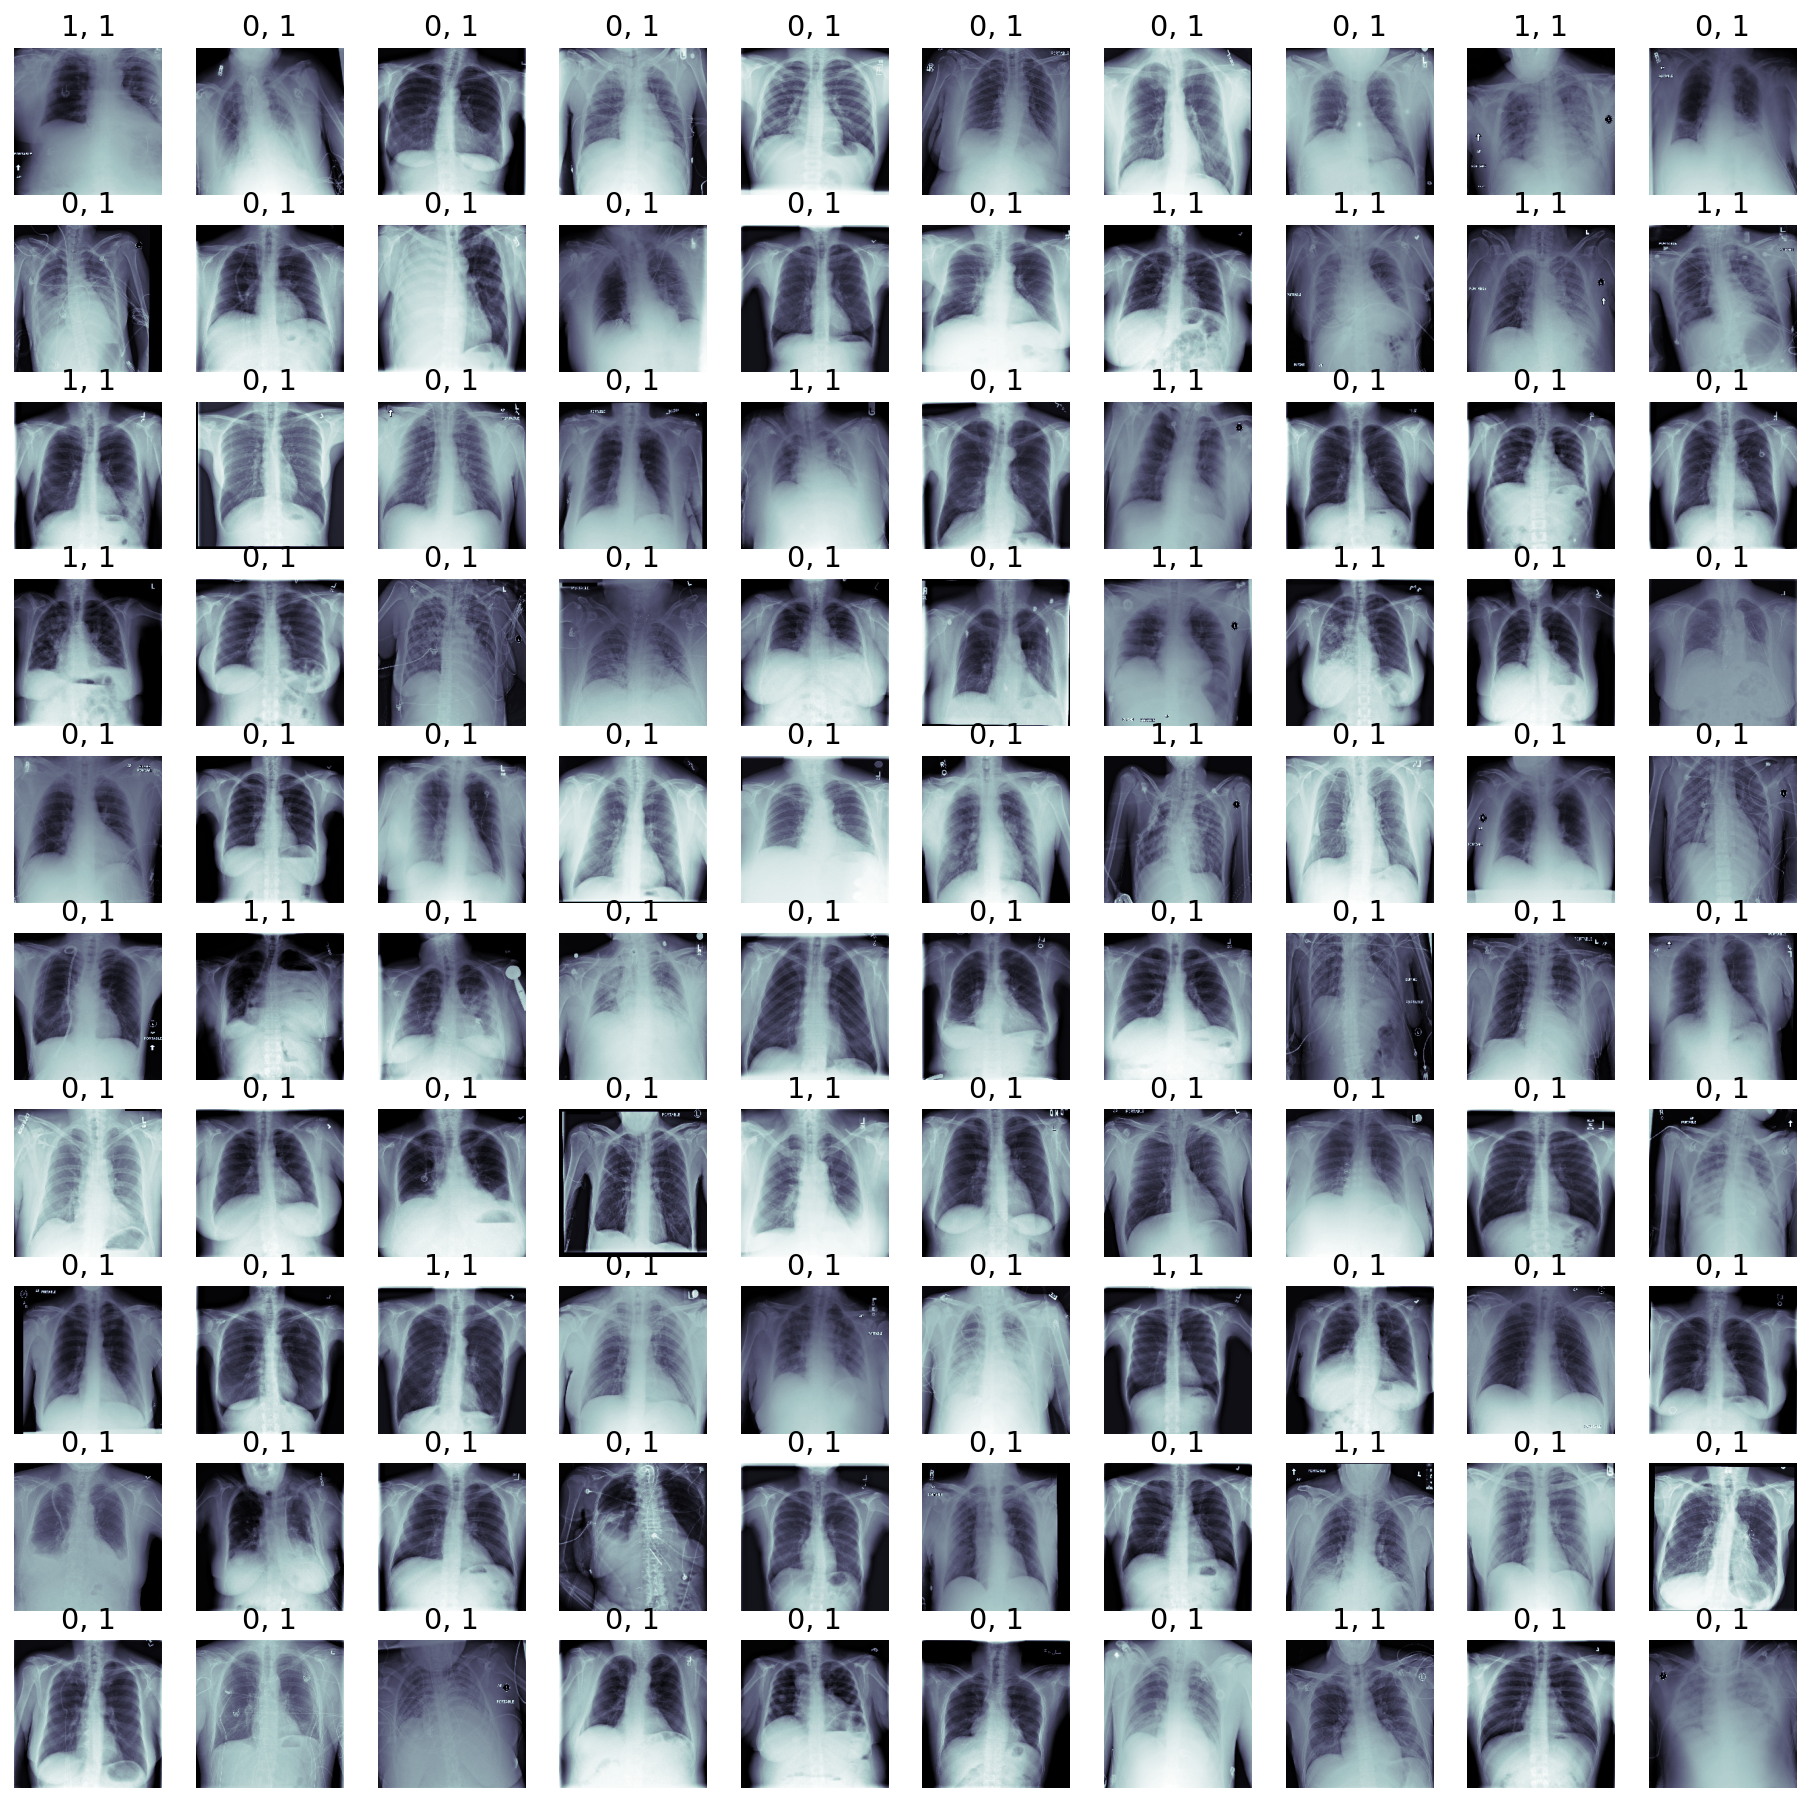

In [98]:
## Let's look at some examples of predicted vs. true with our best model: 

# Todo
fig, m_axs = plt.subplots(10, 10, figsize=(16,16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap='bone')
    if c_y == 1: 
        if pred_Y[i] > BEST_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > BEST_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1
fig.savefig('./out/examples_of_predicted_vs_true_cases_with_{}.png'.format(vgg_model_v2.name))

In [99]:
## Save model architecture.
save_model_architecture(model=vgg_model_v3)

In [100]:
val_data['predicted'] = pred_Y_vgg_model_v2
val_data['predictions'] = val_data.apply(
    lambda df: 1. if df['predicted'] >= BEST_THRESHOLD else .0, axis=1)

val_data.sample(20, random_state=RND_STATE)

Image Index                      Finding Labels  Follow-up #  \
59051   00014616_011.png                           Pneumonia           11   
38116   00010007_035.png               Effusion|Infiltration           35   
75702   00018587_001.png                          No Finding            1   
27792   00007233_002.png                          No Finding            2   
7651    00002001_000.png                          No Finding            0   
99244   00026236_013.png                        Cardiomegaly           13   
2866    00000764_002.png                          No Finding            2   
4399    00001200_001.png                          No Finding            1   
69512   00017138_058.png              Infiltration|Pneumonia           58   
61938   00015318_005.png  Atelectasis|Emphysema|Infiltration            5   
105838  00028499_011.png               Effusion|Infiltration           11   
99695   00026412_008.png                          No Finding            8   
36187   00009553_001.png                              Nodule            1   
34937   00009219_007.png                          No Finding            7   
98618   00026073_002.png                          No Finding            2   
1178    00000289_004.png                          No Finding            4   
27315   00007109_027.png                  Fibrosis|Pneumonia           27   
65158   00016085_002.png            Edema|Effusion|Pneumonia            2   
91256   00022764_000.png                  Effusion|Pneumonia            0   
13545   00003523_011.png                           Pneumonia           11   

        Patient ID  Patient Age Patient Gender View Position  \
59051        14616           49              M            AP   
38116        10007           58              M            AP   
75702        18587           66              F            PA   
27792         7233           30              M            AP   
7651          2001           17              M            PA   
99244        26236           37              F            AP   
2866           764           49              M            PA   
4399          1200           22              M            AP   
69512        17138           24              M            AP   
61938        15318           78              F            AP   
105838       28499           20              F            AP   
99695        26412           24              M            PA   
36187         9553           65              M            PA   
34937         9219           52              M            AP   
98618        26073           53              F            PA   
1178           289           68              F            PA   
27315         7109           39              F            PA   
65158        16085           45              F            AP   
91256        22764           70              M            AP   
13545         3523           23              F            AP   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
59051                  2048     2500                        0.168  ...   
38116                  2500     2048                        0.168  ...   
75702                  2542     2991                        0.143  ...   
27792                  2500     2048                        0.171  ...   
7651                   2048     2500                        0.168  ...   
99244                  3056     2544                        0.139  ...   
2866                   2500     2048                        0.168  ...   
4399                   2500     2048                        0.171  ...   
69512                  2500     2048                        0.168  ...   
61938                  2500     2048                        0.168  ...   
105838                 3056     2544                        0.139  ...   
99695                  2650     2561                        0.143  ...   
36187                  2500     2048                        0.168  ...   
34937         

In [101]:
## Compute the positives and negatives predicted by the model.
tn, fp, fn, tp = confusion_matrix(
    val_data.Pneumonia.values,
    val_data.predictions.values,
    labels=[0,1]).ravel()

print(f'True Negatives: {tn: .0f}')
print(f'False Positives: {fp: .0f}')
print(f'False Negatives: {fn: .0f}')
print(f'True Positives: {tp: .0f}')

True Negatives:  640
False Positives:  504
False Negatives:  164
True Positives:  122


In [102]:
## Determine pred_Y_vgg_model_v2's performance without other diseases.
sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)

print(f'Sensitivity: %.3f' % sensitivity)
print(f'Specificity: %.3f' % specificity)

Sensitivity: 0.427
Specificity: 0.559


In [103]:
## These are the top five diseases that comorbid with Pneumonia, according to the data:
for item in ['Atelectasis', 'Consolidation', 'Edema', 'Effusion', 'Infiltration']:
    tn, fp, fn, tp = confusion_matrix(
        val_data[val_data[item]==1].Pneumonia.values,
        val_data[val_data[item]==1].predictions.values,
        labels=[0,1]).ravel()
    
    sensitivity = tp / (tp+fn)
    specificity = tn / (tn+fp)

    print('For {}:'.format(item.upper()))
    print('--> Sensitivity: %.3f' % sensitivity)
    print('--> Specificity: %.3f\n' % specificity)


For ATELECTASIS:
--> Sensitivity: 0.455
--> Specificity: 0.537

For CONSOLIDATION:
--> Sensitivity: 0.400
--> Specificity: 0.633

For EDEMA:
--> Sensitivity: 0.449
--> Specificity: 0.600

For EFFUSION:
--> Sensitivity: 0.431
--> Specificity: 0.597

For INFILTRATION:
--> Sensitivity: 0.433
--> Specificity: 0.540



## Current Limitations

> For convenience we shall refer to **Model 2** as the Algorithm…
- The presence of other diseases like Atelectasis, Edema, and Effusion, played an impact on the performance of the algorithm in predicting and depicting Pneumonia cases from the X-rays. This is verified by observing the rather lower performance outputs (as shown above).
- Such diseases when comorbid with Pneumonia may well have had an impact on the algorithms’ Sensitivity and Specificity (see the above corresponding results for verification).
- When trying to accurately predict Pneumonia cases, while other diseases such as the top five mentioned above are present, chances are higher for the algorithm’s specificity to be impacted, thus leading to several unwanted/undesirable False Positives in the in the results.

In [104]:
## Number of Pneumonia and Non-Pneumonia cases in the data set.
pos_pneumonia = all_xray_df[all_xray_df['Pneumonia']==1]
neg_pneumonia = all_xray_df[all_xray_df['Pneumonia']==0]

print('Total Pneumonia cases in the data: '+ str(len(pos_pneumonia)))
print('Total Non-Pneumonia cases in the data: {}'.format(len(neg_pneumonia)))
print('Percentage (%) of Pneumonia cases in the data: {}%'.format(
    np.round(100*len(pos_pneumonia)/(len(pos_pneumonia)+len(neg_pneumonia)), 2)))

Total Pneumonia cases in the data: 1431
Total Non-Pneumonia cases in the data: 110689
Percentage (%) of Pneumonia cases in the data: 1.28%


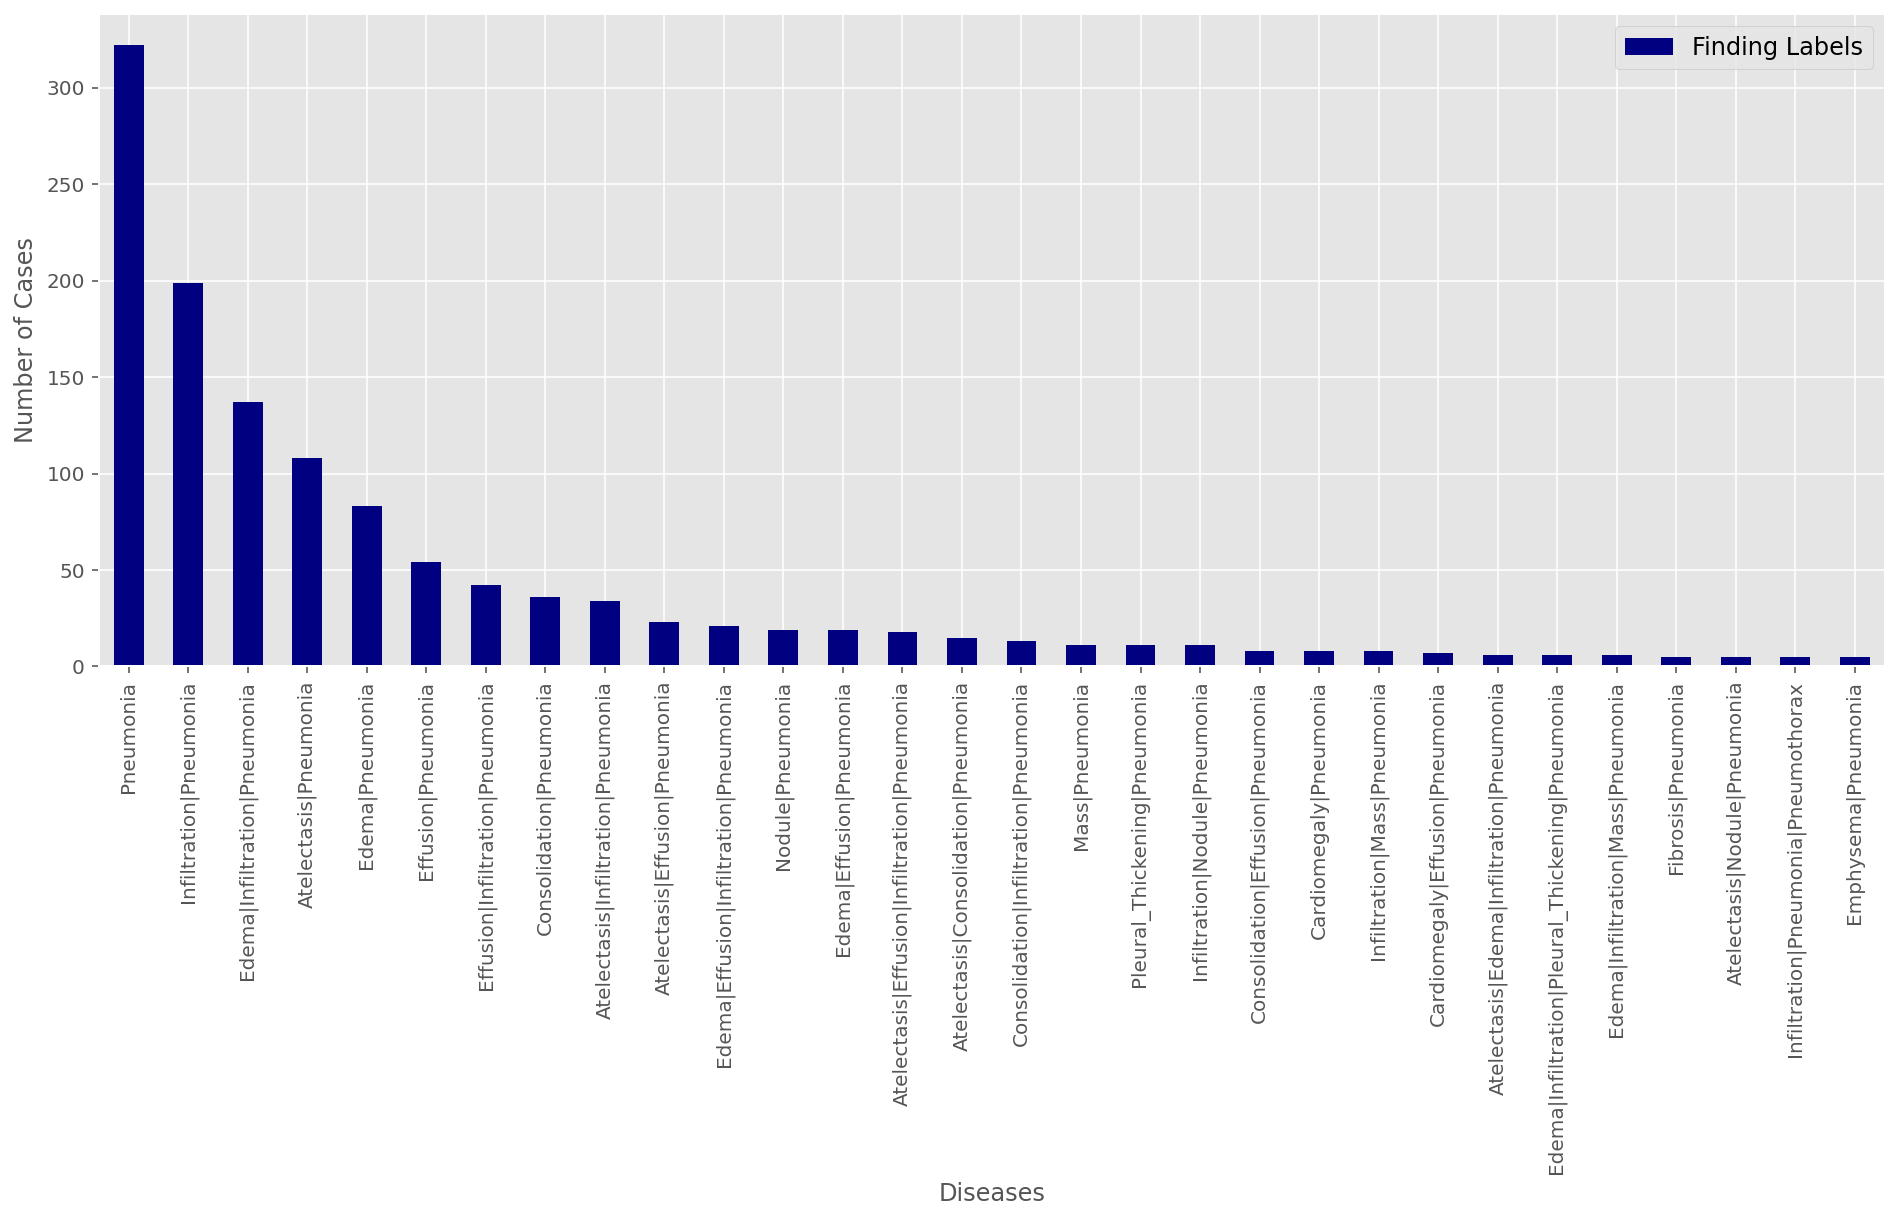

In [105]:
## Pneumonia omorbitiy with other diseases (plot).
plt.figure(figsize=(16,6))
pos_pneumonia['Finding Labels'].value_counts()[0:30].plot(kind='bar', color='navy')
plt.xlabel('Diseases')
plt.ylabel('Number of Cases')
plt.legend(loc='best', fontsize='large')
plt.savefig('./out/Pneumonia_Omorbitiy_with_Other_Diseases.png', dpi=300)

## References

- Daniel S. Kermany et. al., “Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning”, DOI: <https://doi.org/10.1016/j.cell.2018.02.010>.
- K. Scott Mader, “Train Simple XRay CNN”, visited November 2021. URL: <https://www.kaggle.com/kmader/train-simple-xray-cnn>.
- K. Scott Mader, “Cardiomegaly Pretrained-VGG16”, visited November 2021. URL: <https://www.kaggle.com/kmader/cardiomegaly-pretrained-vgg16> 
- Rajpurkar et. al., “CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning”, PDF: <https://arxiv.org/pdf/1711.05225.pdf>.
- Li Yao et. al., “Learning to Diagnose from Scratch by Exploiting Dependencies among Label”, PDF: <https://arxiv.org/pdf/1710.10501.pdf>.
- Wang et. al., “ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases”, PDF: <https://arxiv.org/pdf/1705.02315.pdf>.
Luke Oakden-Rayner, “CheXNet: an in-depth review”, visited November 2021. URL: <https://lukeoakdenrayner.wordpress.com/2018/01/24/chexnet-an-in-depth-review/>.

In [106]:
## We are done with this notebook!
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}